# **California Wildfire Prediction - Tabular Project**
## Mariah Noelle Cornelio

# ***FEASABILITY***

## **Define Project**


The goal of this project is to predict whether a wildfire will occur on a given day in California based on what the weather/humidity/wind speed/temperatures look like 30 days prior to a fire. This dataset uses historical environmental data in the state of California from 1984 to present day. 
- **Goal:** Create an algorithm that predicts when a fire will occur in a California region and provide analytics of weather patterns days prior to an event using LSTM. 
- **Project Link:** https://zenodo.org/records/14712845
- **Type of Machine Learning:** Supervised Binary Classification

## **Data Loading and Initial Look**

**Load the data and packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For easy correlation plot
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("/Users/marielle/Desktop/CA_Weather_Fire_Dataset_1984-2025.csv")
df.head(5)

DATE  PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  FIRE_START_DAY  \
0  1/1/84            0.0      79.0      51.0            4.70           False   
1  1/2/84            0.0      71.0      46.0            5.59           False   
2  1/3/84            0.0      70.0      47.0            5.37           False   
3  1/4/84            0.0      76.0      45.0            4.70           False   
4  1/5/84            0.0      74.0      49.0            5.14           False   

   YEAR  TEMP_RANGE  WIND_TEMP_RATIO  MONTH  SEASON  LAGGED_PRECIPITATION  \
0  1984        28.0         0.059494      1  Winter                   0.0   
1  1984        25.0         0.078732      1  Winter                   0.0   
2  1984        23.0         0.076714      1  Winter                   0.0   
3  1984        31.0         0.061842      1  Winter                   0.0   
4  1984        25.0         0.069459      1  Winter                   0.0   

   LAGGED_AVG_WIND_SPEED  DAY_OF_YEAR  
0                  4.700            1  
1                  5.145            2  
2                  5.220            3  
3                  5.090            4  
4                  5.100            5

**Count the number of rows (data points) and features**

In [3]:
df.shape

# 14,988 rows and 14 columns

(14988, 14)

In [4]:
df.columns

# Description for each column can be found on the website source link above

Index(['DATE', 'PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
       'FIRE_START_DAY', 'YEAR', 'TEMP_RANGE', 'WIND_TEMP_RATIO', 'MONTH',
       'SEASON', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED',
       'DAY_OF_YEAR'],
      dtype='object')

In [5]:
df.dtypes

DATE                      object
PRECIPITATION            float64
MAX_TEMP                 float64
MIN_TEMP                 float64
AVG_WIND_SPEED           float64
FIRE_START_DAY              bool
YEAR                       int64
TEMP_RANGE               float64
WIND_TEMP_RATIO          float64
MONTH                      int64
SEASON                    object
LAGGED_PRECIPITATION     float64
LAGGED_AVG_WIND_SPEED    float64
DAY_OF_YEAR                int64
dtype: object

From this, we'd want to move FIRE_START_DAY into the last column since it is our target variable and then change it into 0's and 1's since it is currently a boolean.

**Any missing values?**

In [6]:
df.isnull().sum()

# There are some null values we need to check out and address

DATE                      0
PRECIPITATION             1
MAX_TEMP                  1
MIN_TEMP                  1
AVG_WIND_SPEED           12
FIRE_START_DAY            0
YEAR                      0
TEMP_RANGE                1
WIND_TEMP_RATIO          12
MONTH                     0
SEASON                    0
LAGGED_PRECIPITATION      0
LAGGED_AVG_WIND_SPEED     0
DAY_OF_YEAR               0
dtype: int64

**Make a table, where each row is a feature or collection of features:**
- **Is the feature categorical or numerical**
- **What values? e.g. for categorical: "0,1,2", e.g. for numerical specify the range**
- **How many missing values**
- **Do you see any outliers? Define outlier.**

In [7]:
# IQR function to detect outliers
def detect_outliers(series):
    if not pd.api.types.is_numeric_dtype(series):
        return "N/A"
    # Drop NaNs first
    series = series.dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

In [8]:
# Making the table
summary = []

for col in df.columns:
    series = df[col]
    n_missing = series.isnull().sum()
    unique_vals = series.dropna().unique()
    
    # Determine feature type
    if pd.api.types.is_numeric_dtype(series) and not pd.api.types.is_bool_dtype(series):
        ftype = "Numerical"
        val_range = f"{series.min():.2f} to {series.max():.2f}"
        outliers = detect_outliers(series)
    elif pd.api.types.is_bool_dtype(series) or series.nunique() <= 10:
        ftype = "Categorical"
        val_range = ', '.join(map(str, sorted(series.dropna().unique())))
        outliers = "N/A"
    else:
        ftype = "Categorical"
        val_range = ', '.join(map(str, sorted(series.dropna().unique())[:5]))
        if series.nunique() > 5:
            val_range += ", ..."
        outliers = "N/A"

    summary.append({
        "Feature": col,
        "Type": ftype,
        "Values / Range": val_range,
        "Missing Values": n_missing,
        "Outliers": outliers
    })

summary_df = pd.DataFrame(summary)
summary_df

Feature         Type  \
0                    DATE  Categorical   
1           PRECIPITATION    Numerical   
2                MAX_TEMP    Numerical   
3                MIN_TEMP    Numerical   
4          AVG_WIND_SPEED    Numerical   
5          FIRE_START_DAY  Categorical   
6                    YEAR    Numerical   
7              TEMP_RANGE    Numerical   
8         WIND_TEMP_RATIO    Numerical   
9                   MONTH    Numerical   
10                 SEASON  Categorical   
11   LAGGED_PRECIPITATION    Numerical   
12  LAGGED_AVG_WIND_SPEED    Numerical   
13            DAY_OF_YEAR    Numerical   

                                 Values / Range  Missing Values Outliers  
0   1/1/00, 1/1/01, 1/1/02, 1/1/03, 1/1/04, ...               0      N/A  
1                                  0.00 to 4.53               1     1381  
2                               50.00 to 106.00               1      161  
3                                33.00 to 77.00               1        2  
4                                 1.79 to 26.17              12      479  
5                                   False, True               0      N/A  
6                            1984.00 to 2025.00               0        0  
7                                 2.00 to 41.00               1      573  
8                                  0.02 to 0.46              12      733  
9                                 1.00 to 12.00               0        0  
10                 Fall, Spring, Summer, Winter               0      N/A  
11                                 0.00 to 8.18               0     3065  
12                                3.23 to 13.93               0      187  
13                               1.00 to 366.00               0        0

**For classification is there class imbalance?**

In [9]:
df['FIRE_START_DAY'].value_counts()
df['FIRE_START_DAY'].value_counts(normalize=True)  # as proportions

False    0.668335
True     0.331665
Name: FIRE_START_DAY, dtype: float64

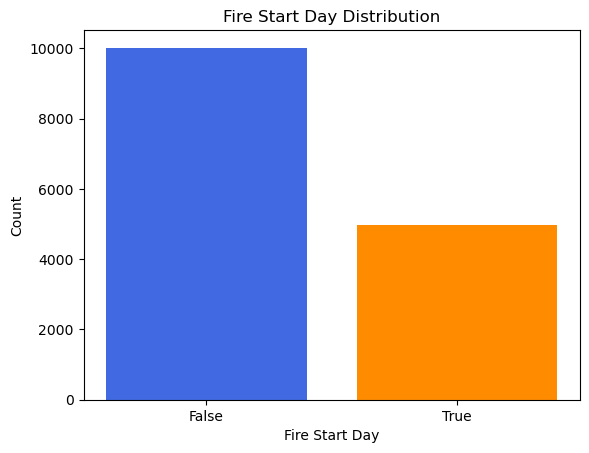

In [10]:
color_map = {True: 'darkorange', False: 'royalblue'}
fire_day_counts = df['FIRE_START_DAY'].value_counts().sort_index()
colors = [color_map[val] for val in fire_day_counts.index]

plt.bar(fire_day_counts.index.astype(str), fire_day_counts.values, color=colors)
plt.title('Fire Start Day Distribution')
plt.xlabel('Fire Start Day')
plt.ylabel('Count')
plt.show()

There seems to be a **moderate class imbalance** that we will have to consider when splitting and training our model. 66% false and 33% true.

**What is the target?**

- **Classification:** The target is encoded as True and False, so we will have to change that later to numerical values 0 and 1.

## **Data Visualization**

**Distribution of Features Against Class (0 and 1)**

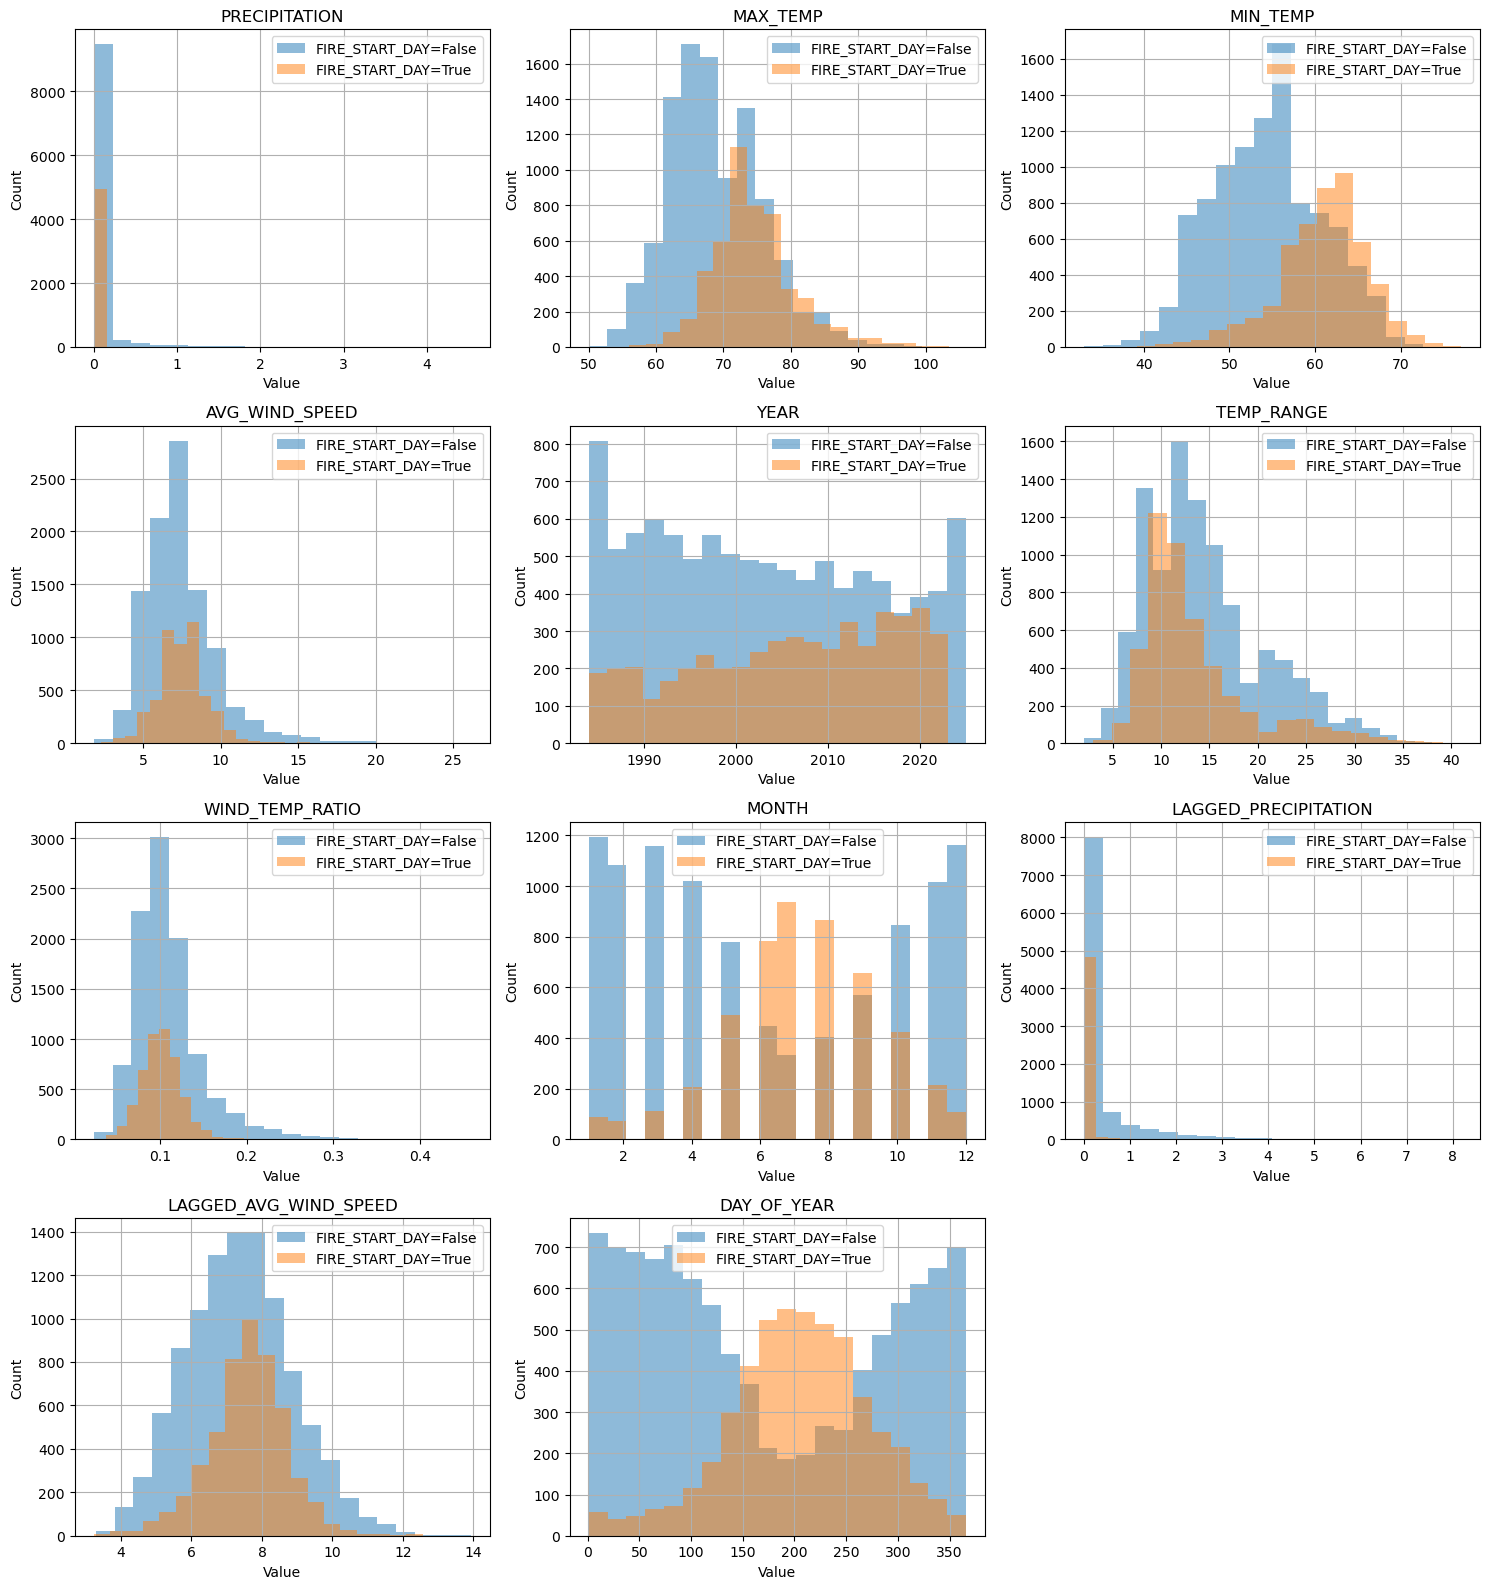

In [11]:
df['FIRE_START_DAY'] = df['FIRE_START_DAY'].astype(str)
numerical_features = df.select_dtypes(include='number').columns.tolist()

n_cols = 3  # number of plots per row
n_rows = (len(numerical_features) + n_cols - 1) // n_cols  # rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    for label in df['FIRE_START_DAY'].unique():
        subset = df[df['FIRE_START_DAY'] == label]
        ax.hist(subset[feature].dropna(), bins=20, alpha=0.5, label=f"FIRE_START_DAY={label}")
    
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True)

# Remove empty subplots if any
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()

**Analysis and Comparison of Distributions Against Classes:**

- Precipitation: Fires can start on days wheere it rains or doesn't rain
- Max_temp: There is a range of overlap in the 60s to high 80s where a fire may or may not start
- Min_temp: Fires don't usually happen on cooler days (< 55)
- Avg_wind_speed: You can see the class imbalance here but fire's will start when wind is present
- Year: The overall trend shows that the number of fires are increasing every year
- Temp_range: Shows that a fire has a higher chance of starting if the temp range between maximum and minimum temperature is higher
- Wind_temp_ratio: Wind and heat interaction can dry out vegetation, increasing the risk of fires
- Month: Fires happen exclusively in June to August but there is an overlap in range for the other months
- Lagged_precipitation: Fires usually start when there is no rain/no dampness
- Lagged_avg_wind_speed: Fires are most likely to occur with higher wind speeds
- Day_of_year: Same thing as Month

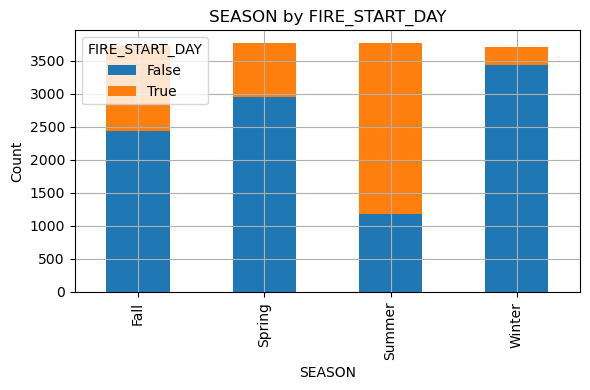

In [12]:
# For categorical features (just Season because we already visualized our target variable)

categorical_features=["SEASON"]

for feature in categorical_features:
    ct = pd.crosstab(df[feature], df['FIRE_START_DAY'])
    ct.plot(kind='bar', stacked=True, figsize=(6, 4))
    plt.title(f"{feature} by FIRE_START_DAY")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="FIRE_START_DAY")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

Fires usually start in the Summer > Fall > Spring > Winter

**Important features for my dataset that I want to use for machine learning:**
- MAX_TEMP
- MIN_TEMP
- WIND_TEMP_RATIO
- PRECIPITATION
- LAGGED PRECIPITATION
- AVG_WIND_SPEED
- LAGGED_AVG_WIND_SPEED
- TEMP_RANGE
- DATE (for LSTM)

**LSTM VISUALIZATION: An example of distributions of features across a timeframe of 30 days prior to a fire**

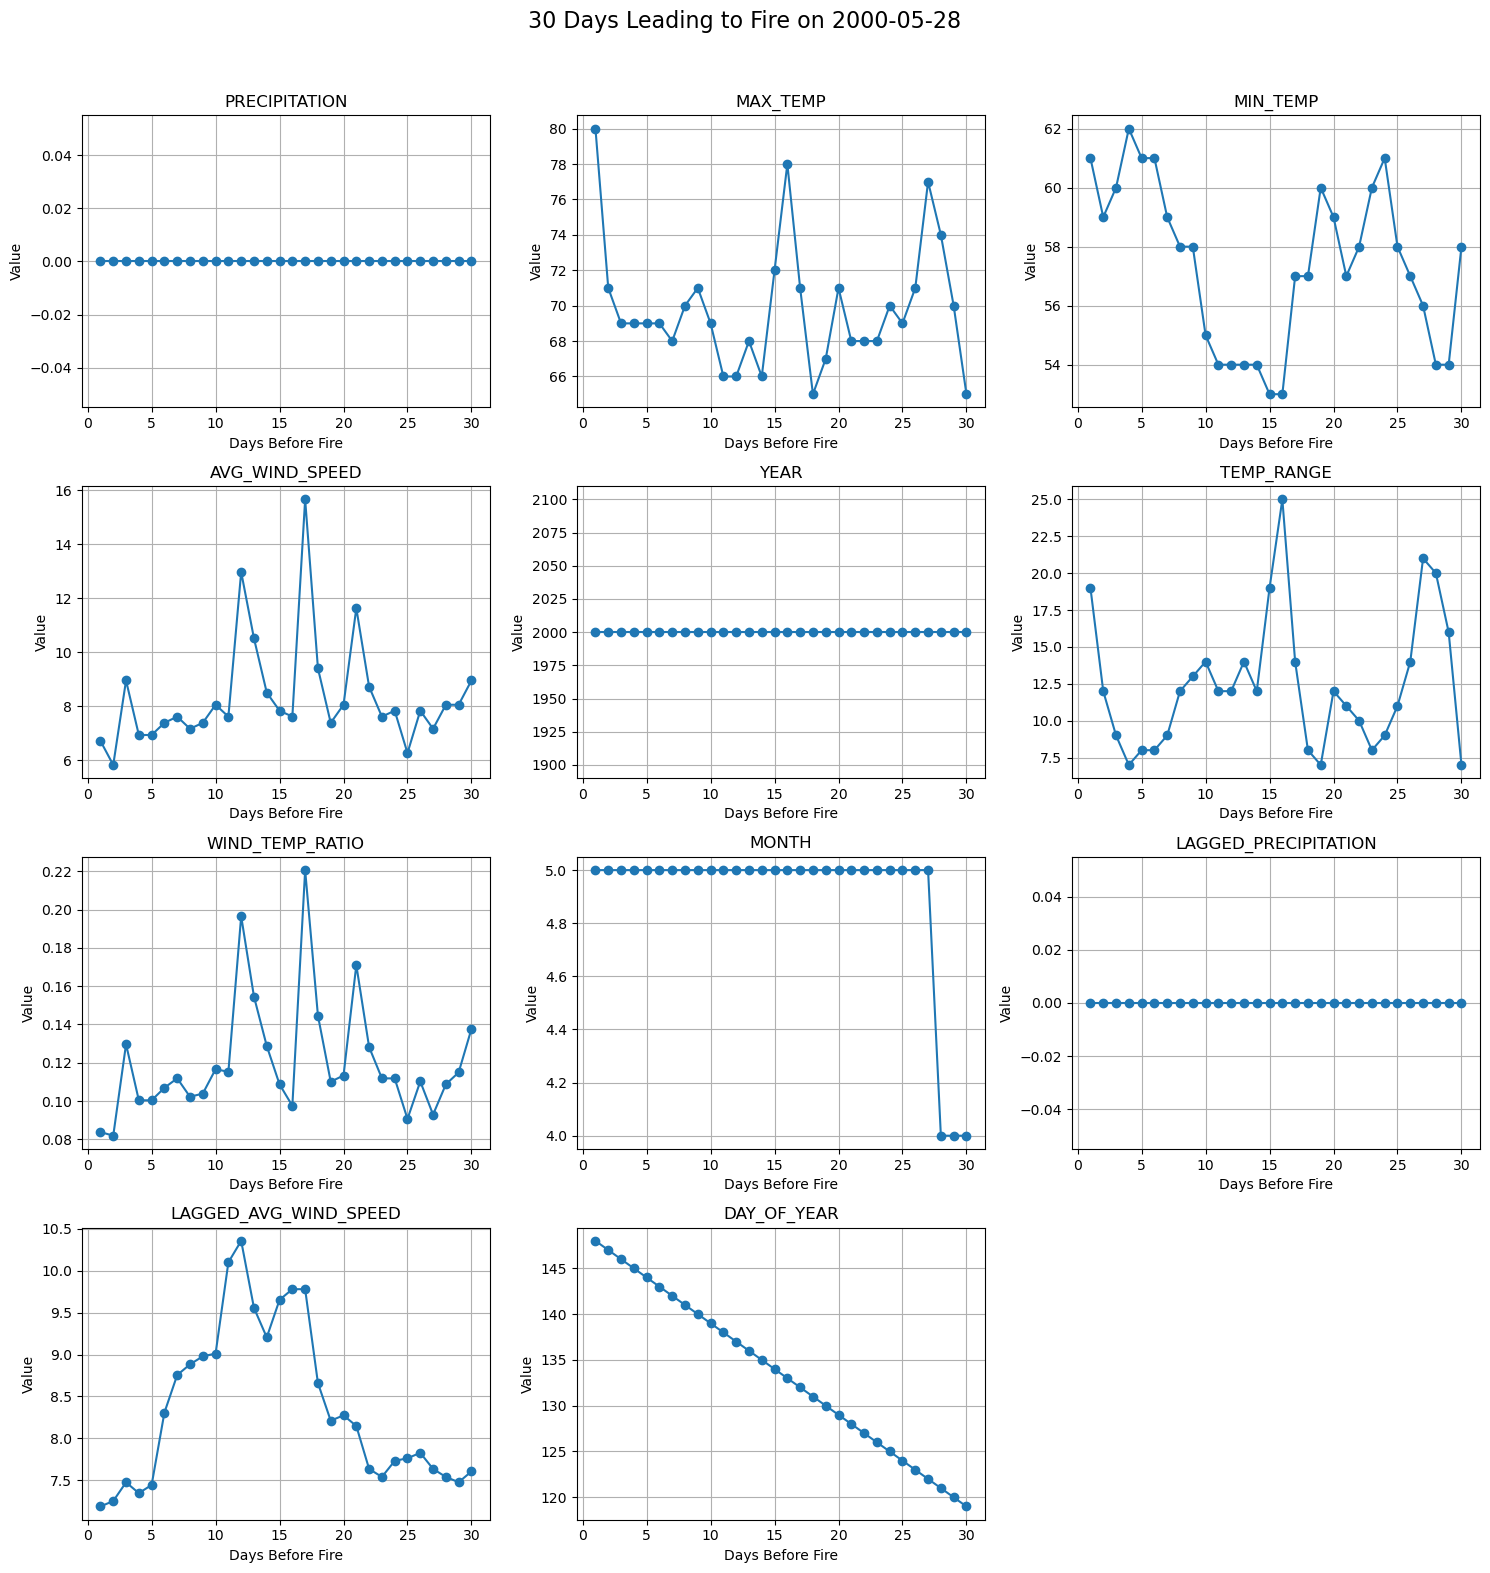

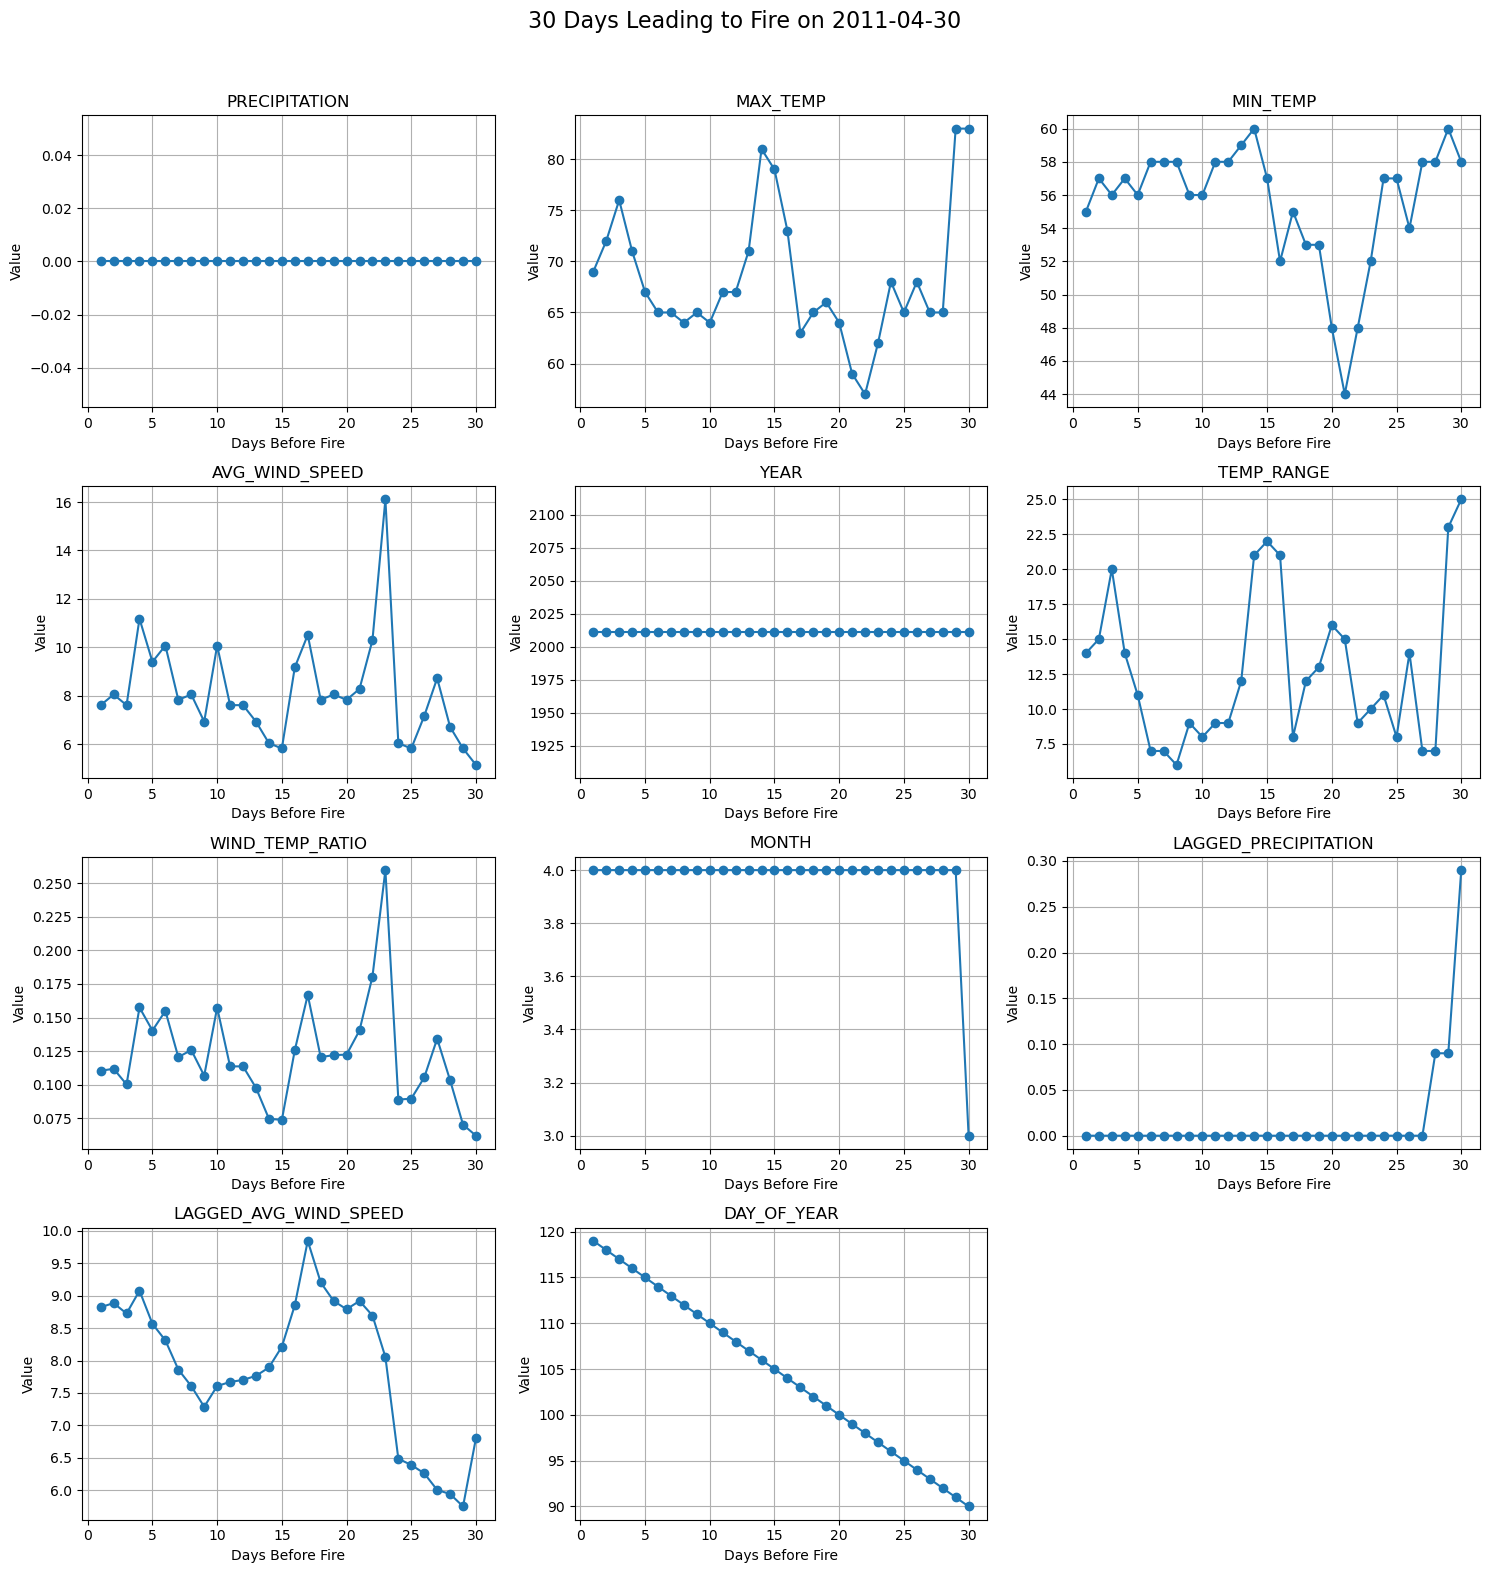

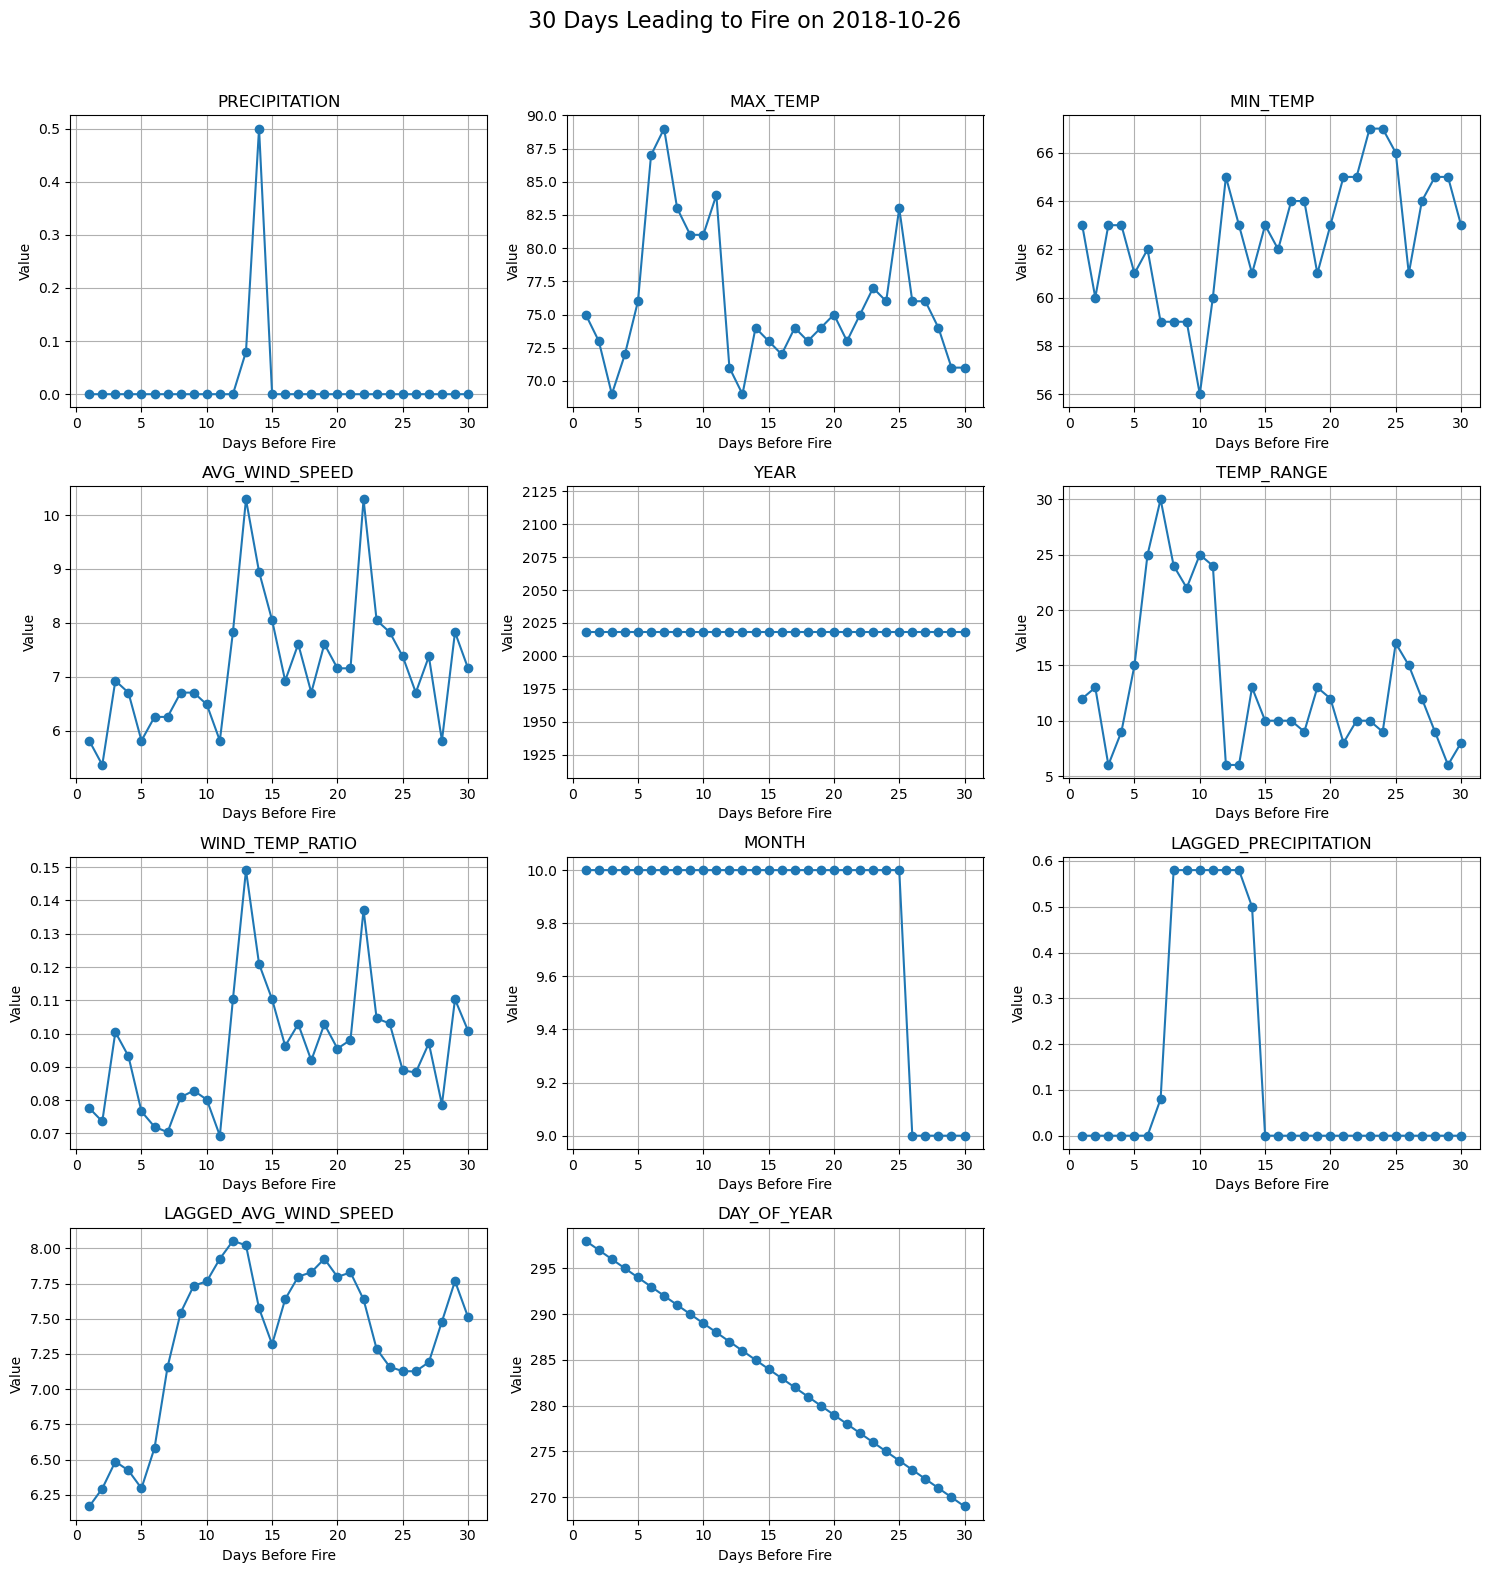

In [13]:
# Making a copy makes sure that the main dataset remains untouched
df_viz = df.copy()

# Ensure date is datetime and data is sorted
df_viz['DATE'] = pd.to_datetime(df_viz['DATE'])
df_viz = df_viz.sort_values('DATE')

# Make sure FIRE_START_DAY is boolean
df_viz['FIRE_START_DAY'] = df_viz['FIRE_START_DAY'].astype(bool)

# Choose a few sample fire events (e.g., 3 random ones)
sample_fire_dates = df_viz[df_viz['FIRE_START_DAY']].sample(n=3, random_state=42)['DATE']

# List of numerical features
feature_names = df_viz.select_dtypes(include='number').columns.tolist()
window_size = 30

# For each fire, plot the 30-day feature history
for i, fire_date in enumerate(sample_fire_dates):
    window = df_viz[(df_viz['DATE'] < fire_date) & (df_viz['DATE'] >= fire_date - pd.Timedelta(days=window_size))].copy()
    
    if len(window) < window_size:
        continue  # Skip incomplete windows
    
    window['Days Before Fire'] = (fire_date - window['DATE']).dt.days
    window = window.sort_values('Days Before Fire')  # So 30 → 1
    
    # Plot in a grid
    n_cols = 3
    n_rows = (len(feature_names) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()
    
    for j, feature in enumerate(feature_names):
        ax = axes[j]
        ax.plot(window['Days Before Fire'], window[feature], marker='o')
        ax.set_title(feature)
        ax.set_xlabel("Days Before Fire")
        ax.set_ylabel("Value")
        ax.grid(True)
    
    for k in range(len(feature_names), len(axes)):
        fig.delaxes(axes[k])
    
    fig.suptitle(f"30 Days Leading to Fire on {fire_date.date()}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


**30 Days Before 05-28-2000 Fire:**
- Precipitation: 0
- Max_temp: Fluctuates. The day before the fire is significantly hotter
- Min_temp: Fluctuates. Where there is a drop around 15 days before the fire.
- Avg_wind_speed: Fluctuates. Wind speed is at peak around 15 days before the fire.
- Temp_range: Fluctuates. Peak is around 15 days before a fire.
- Wind_temp_ratio: Fluctuates. Peakrs are around 15-20 days before the fire.
- Lagged_precipitation: 0
- Lagged_avg_wind_speed: Bell-curve. Peak is 10-15 days before the fire.

**30 Days Before 04-30-2011 Fire:**

- Precipitation: 0
- Max_temp: Fluctuates. 15 days prior to the fire is peak. There is a dip in temperature around 20-25 days before the fire.
- Min_temp: Fluctuates. Where there is a drop around 20 days before the fire.
- Avg_wind_speed: Fluctuates. Wind speed is at peak around 20 days before the fire.
- Temp_range: Fluctuates. Peak is around 15 days before a fire
- Wind_temp_ratio: Fluctuates. Peakrs are around 20-25 days before the fire.
- Lagged_precipitation: 0, but can happen 25 days before a fire 
- Lagged_avg_wind_speed: Bell-curve. Peak is 10-15 days before the fire

**30 Days Before 10-26-2018 Fire:**
- Precipitation: Some rain 15 days before the fire
- Max_temp: Fluctuates. Drops 10-20 days before the fire.
- Min_temp: Fluctuates. Drops 10 days before a fire
- Avg_wind_speed: Fluctuates. Wind speed is at peak around 15 and 25 days before the fire.
- Temp_range: Fluctuates. Peak is around 5 days before a fire, but there is also a significant drop 10-15 days before
- Wind_temp_ratio: Fluctuates. Peakrs are around 10-15 days before the fire.
- Lagged_precipitation: Usually 0 but can even happen a week before a fire
- Lagged_avg_wind_speed: Highest around 10 days before

**IMPORTANT TRENDS I'VE NOTICED**
- Indicators happen 1-2 weeks before a fire start where, temperatures seem to drop and wind speeds increase. Why?
    - Cold air brings drier winds and dries out vegetation

## **Additional Visualization and Analysis to Help Me Understand My Data Better**

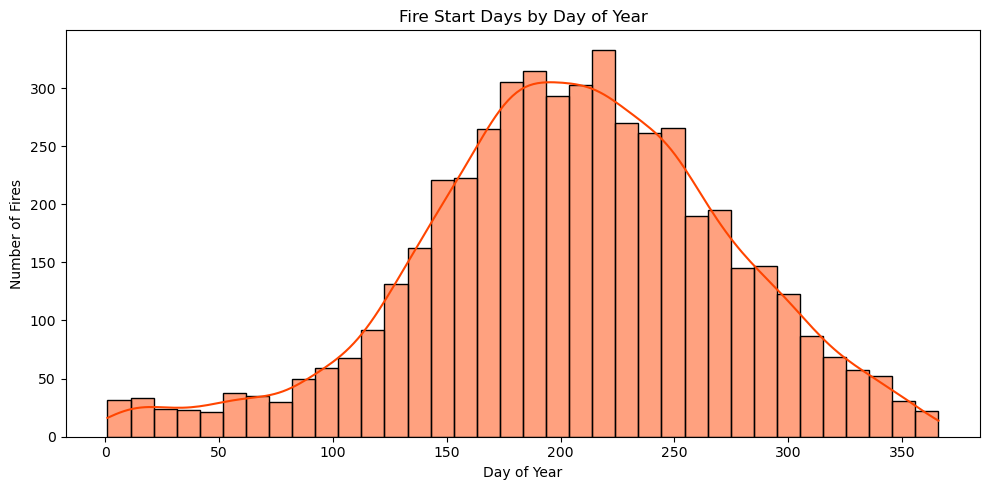

In [15]:
# Fire start by day of the year
plt.figure(figsize=(10, 5))
sns.histplot(data=df[df['FIRE_START_DAY'] == "True"], x='DAY_OF_YEAR', bins=36, color='orangered', kde=True)
plt.title('Fire Start Days by Day of Year')
plt.xlabel('Day of Year')
plt.ylabel('Number of Fires')
plt.tight_layout()
plt.show()

From this we see that fires occur most frequently from days 155-250 which is roughly around the months of June to September, agreeing with our seasonal data (fires start mostly in summer).

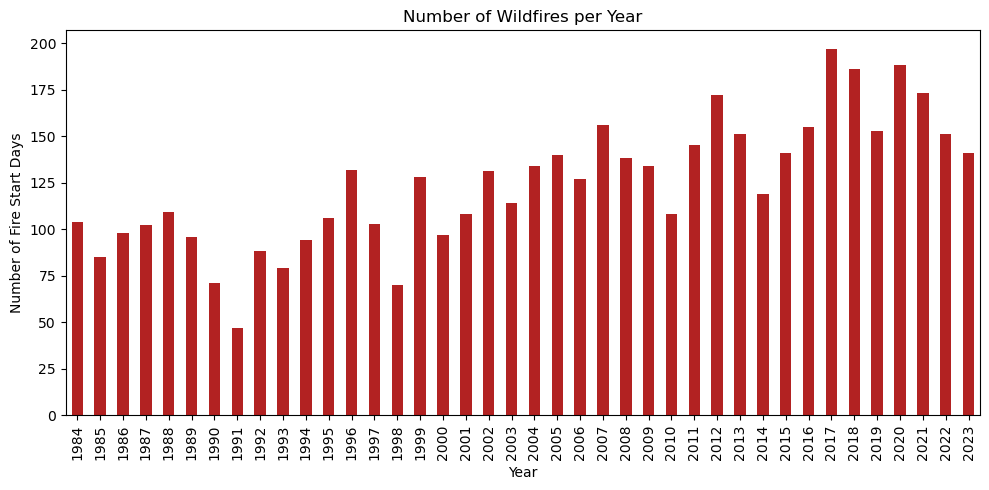

In [16]:
# Number of fires per year

fires_per_year = df[df['FIRE_START_DAY'] == "True"].groupby('YEAR').size()

plt.figure(figsize=(10, 5))
fires_per_year.plot(kind='bar', color='firebrick')
plt.title('Number of Wildfires per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fire Start Days')
plt.tight_layout()
plt.show()

There is an upwards trend with each year.

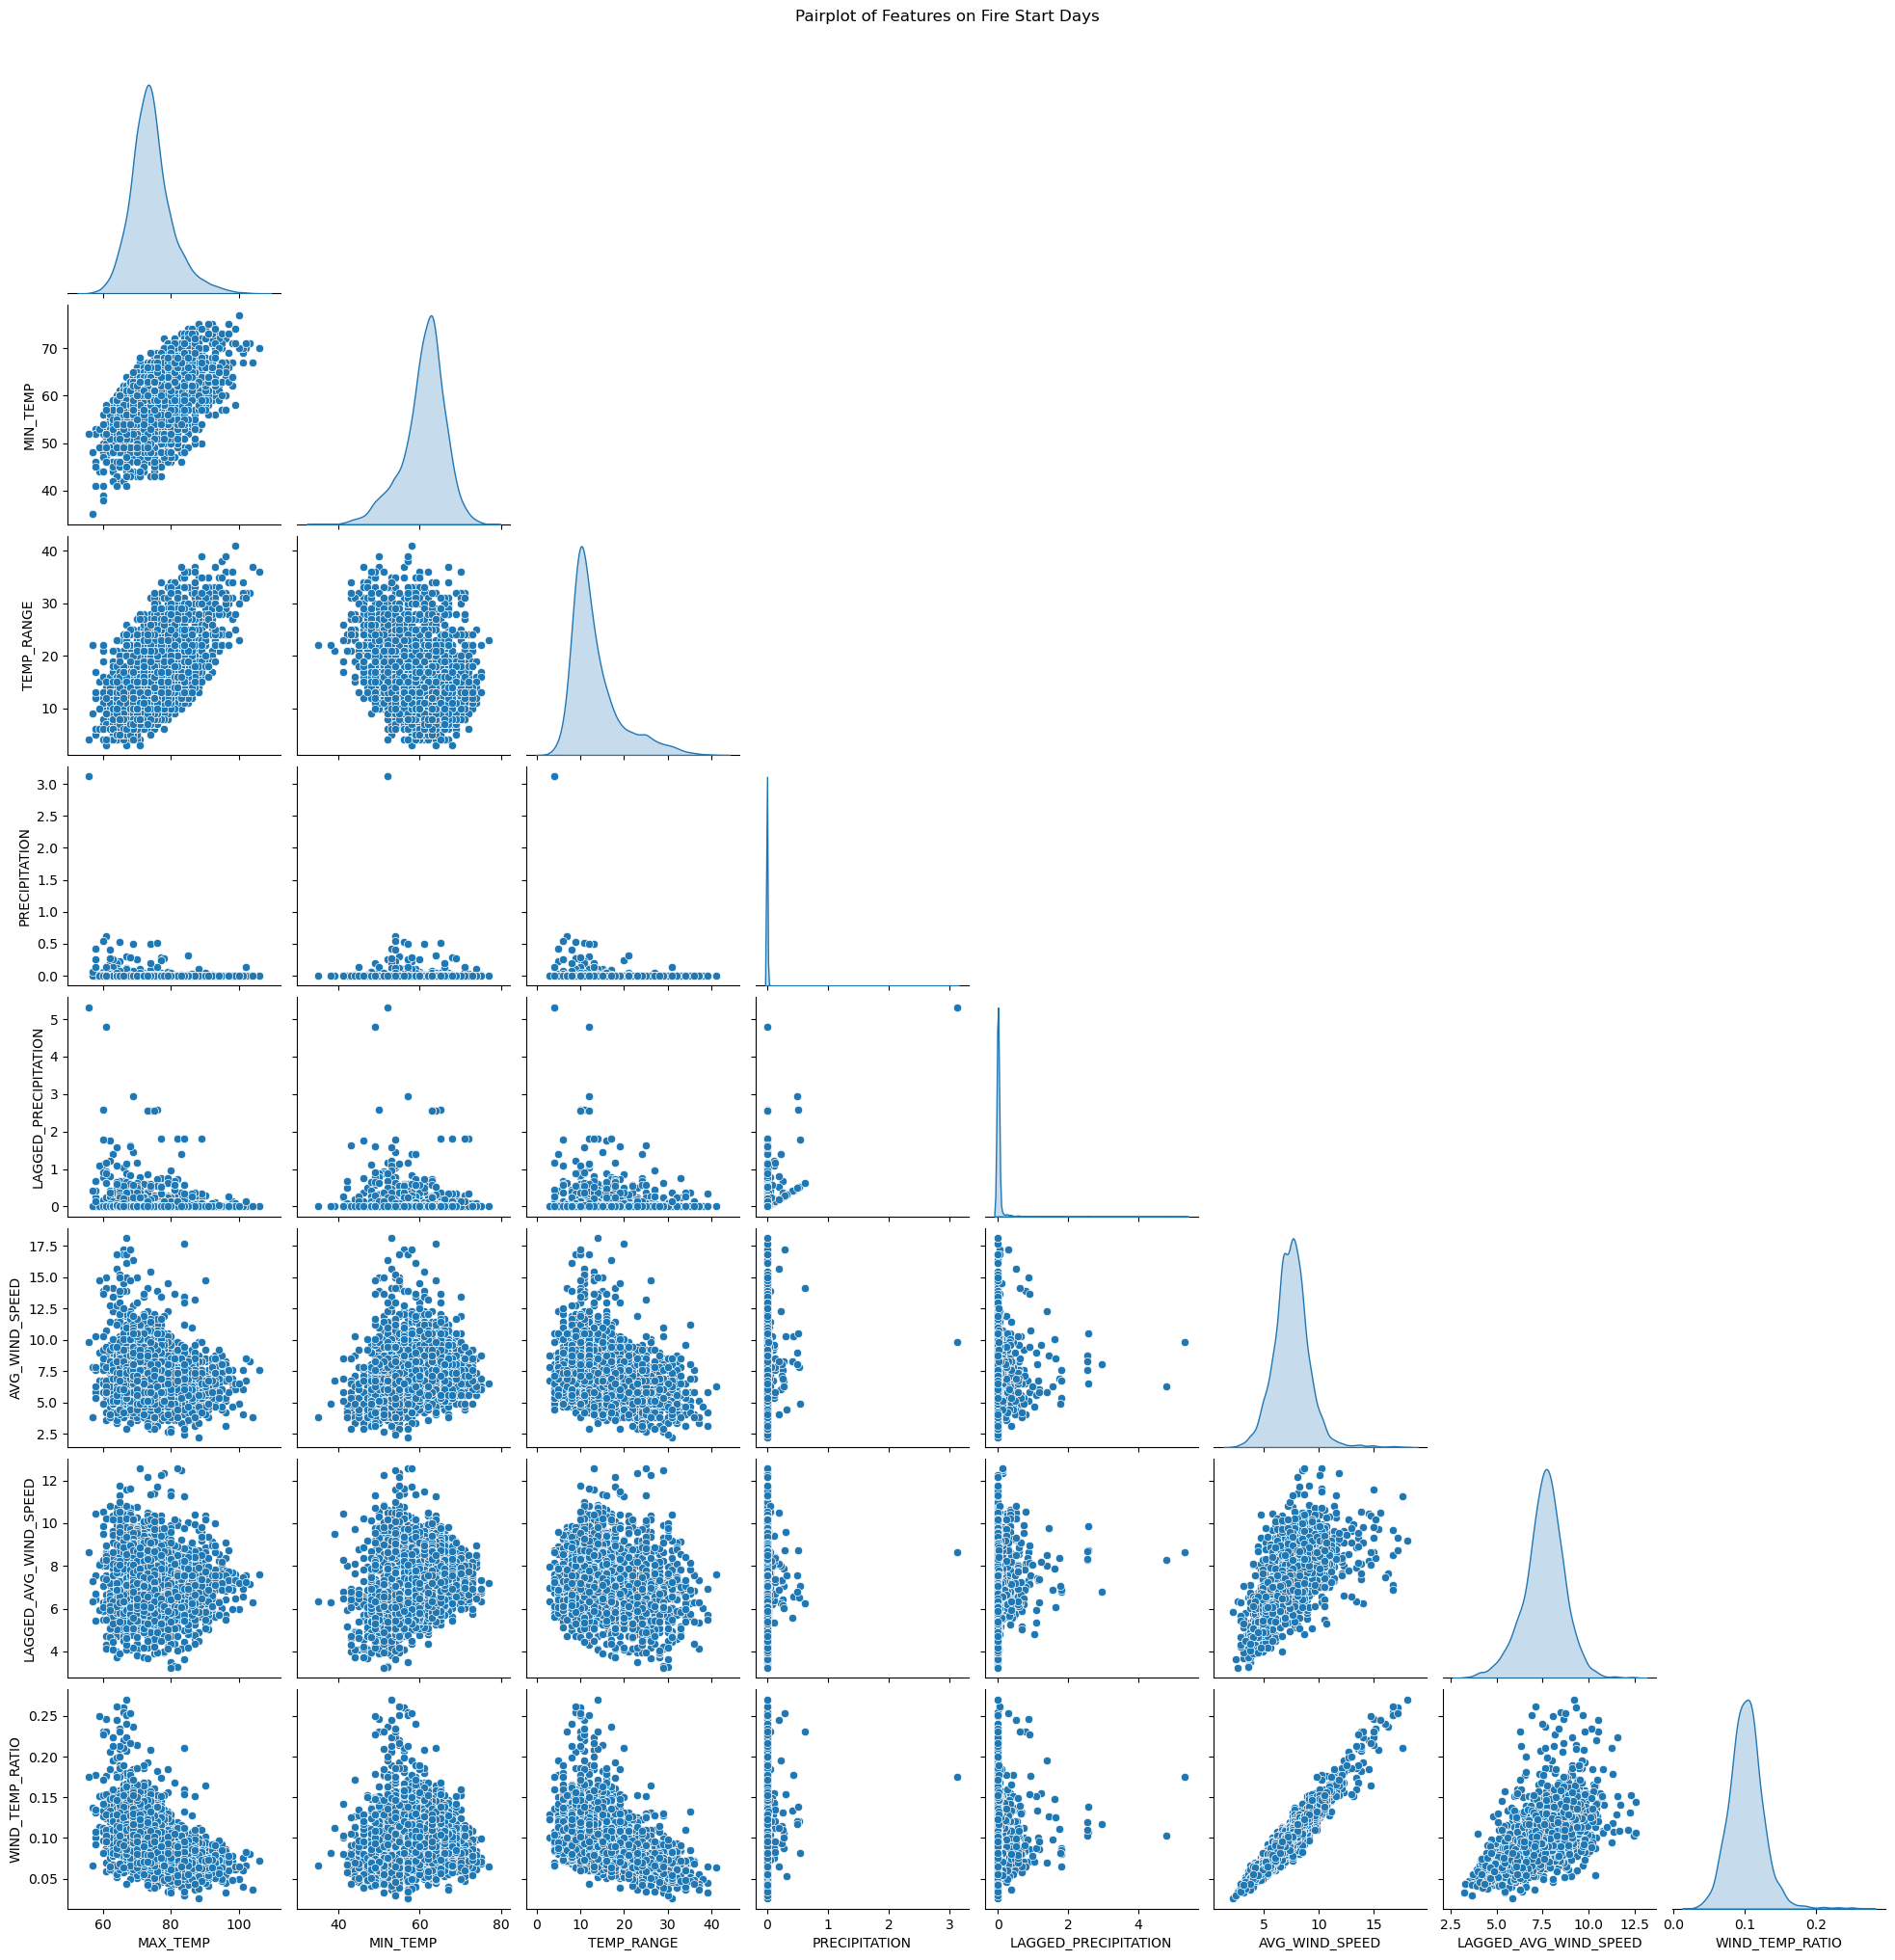

In [19]:
# Pairplot of features for fire start days
fire_days = df[df['FIRE_START_DAY'] == "True"]
numerical_features = [
    'MAX_TEMP', 'MIN_TEMP', 'TEMP_RANGE',
    'PRECIPITATION', 'LAGGED_PRECIPITATION',
    'AVG_WIND_SPEED', 'LAGGED_AVG_WIND_SPEED',
    'WIND_TEMP_RATIO']

sns.pairplot(fire_days[numerical_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Features on Fire Start Days', y=1.02)
plt.show()

Reading pairplots can be overwhelming sometimes but here's what each pattern usually means for easy reference:
- Blobs: Little to no correlation
- Linear: Positive/negative correlation
- Vertical line: X-variable has unique values or is categorical
- Horizontal line: Y-variable has unique values or is categorical
- The Diagonal: Distribution of the features (can be Normal or skewed)

For this dataset, there are some features I want to look at:
- **MAX_TEMP & WIND_TEMP_RATIO shows interaction of heat and wind for drying conditions**
    - Blob shaped like a banana
    - Suggests fire-related drying becomes more stable in hot conditions, wind consistently contributes more
- **PRECIPITATION & MAX_TEMP shows moisture vs heat balance**
    - Horizontal line with one outlier at the top
    - Suggests that heat alone isn’t enough; low precipitation is usually necessary for fire starts
- **MAX_TEMP & MIN_TEMP shows temperature dynamics**
    - Blob going up 
    - Clear positive correlation, hotter days tend to have warmer nights
    - Reflects typical temperature dynamics but doesn’t directly relate to fire prediction
- **PRECIPITATION & LAGGED PRECIPITATION shows current day rainfall vs week's rainfall (if too wet, fires might not start)**
    - Vertical line with one outlier to the right
    - The vertical line suggests that fires can still start even after a wet week, as long as today is dry
- **AVG_WIND_SPEED & LAGGED_AVG_WIND_SPEED shows daily wind speed vs week's wind speed (winds help fire spread faster)**
    - Starts narrow and then fans out as it goes to the right and up
    - When the weekly average wind is low, daily wind tends to be stable. When the weekly average wind is high, daily wind is more variable
    - Suggests unstable wind conditions might increase as sustained wind rises, important for fire spread behavior
- **WIND_TEMP_RATIO & AVG_WIND_SPEED shows wind and heat interaction**
    - Linear positive
    - This is the highly correlated feature with r=0.95
    - Suggests this feature might be redundant—you and should drop one depending on what to use for LSTM
- **TEMP_RANGE & WIND_TEMP_RATIO (hot days and cool nights can dry out vegetation)**
    - Blob shaped like a banana
    - When the temperature doesn’t swing much during the day (low temp range), the wind-temp effect varies a lot
    - This hints that hot, dry, fluctuating days may consistently create fire-prone drying condition

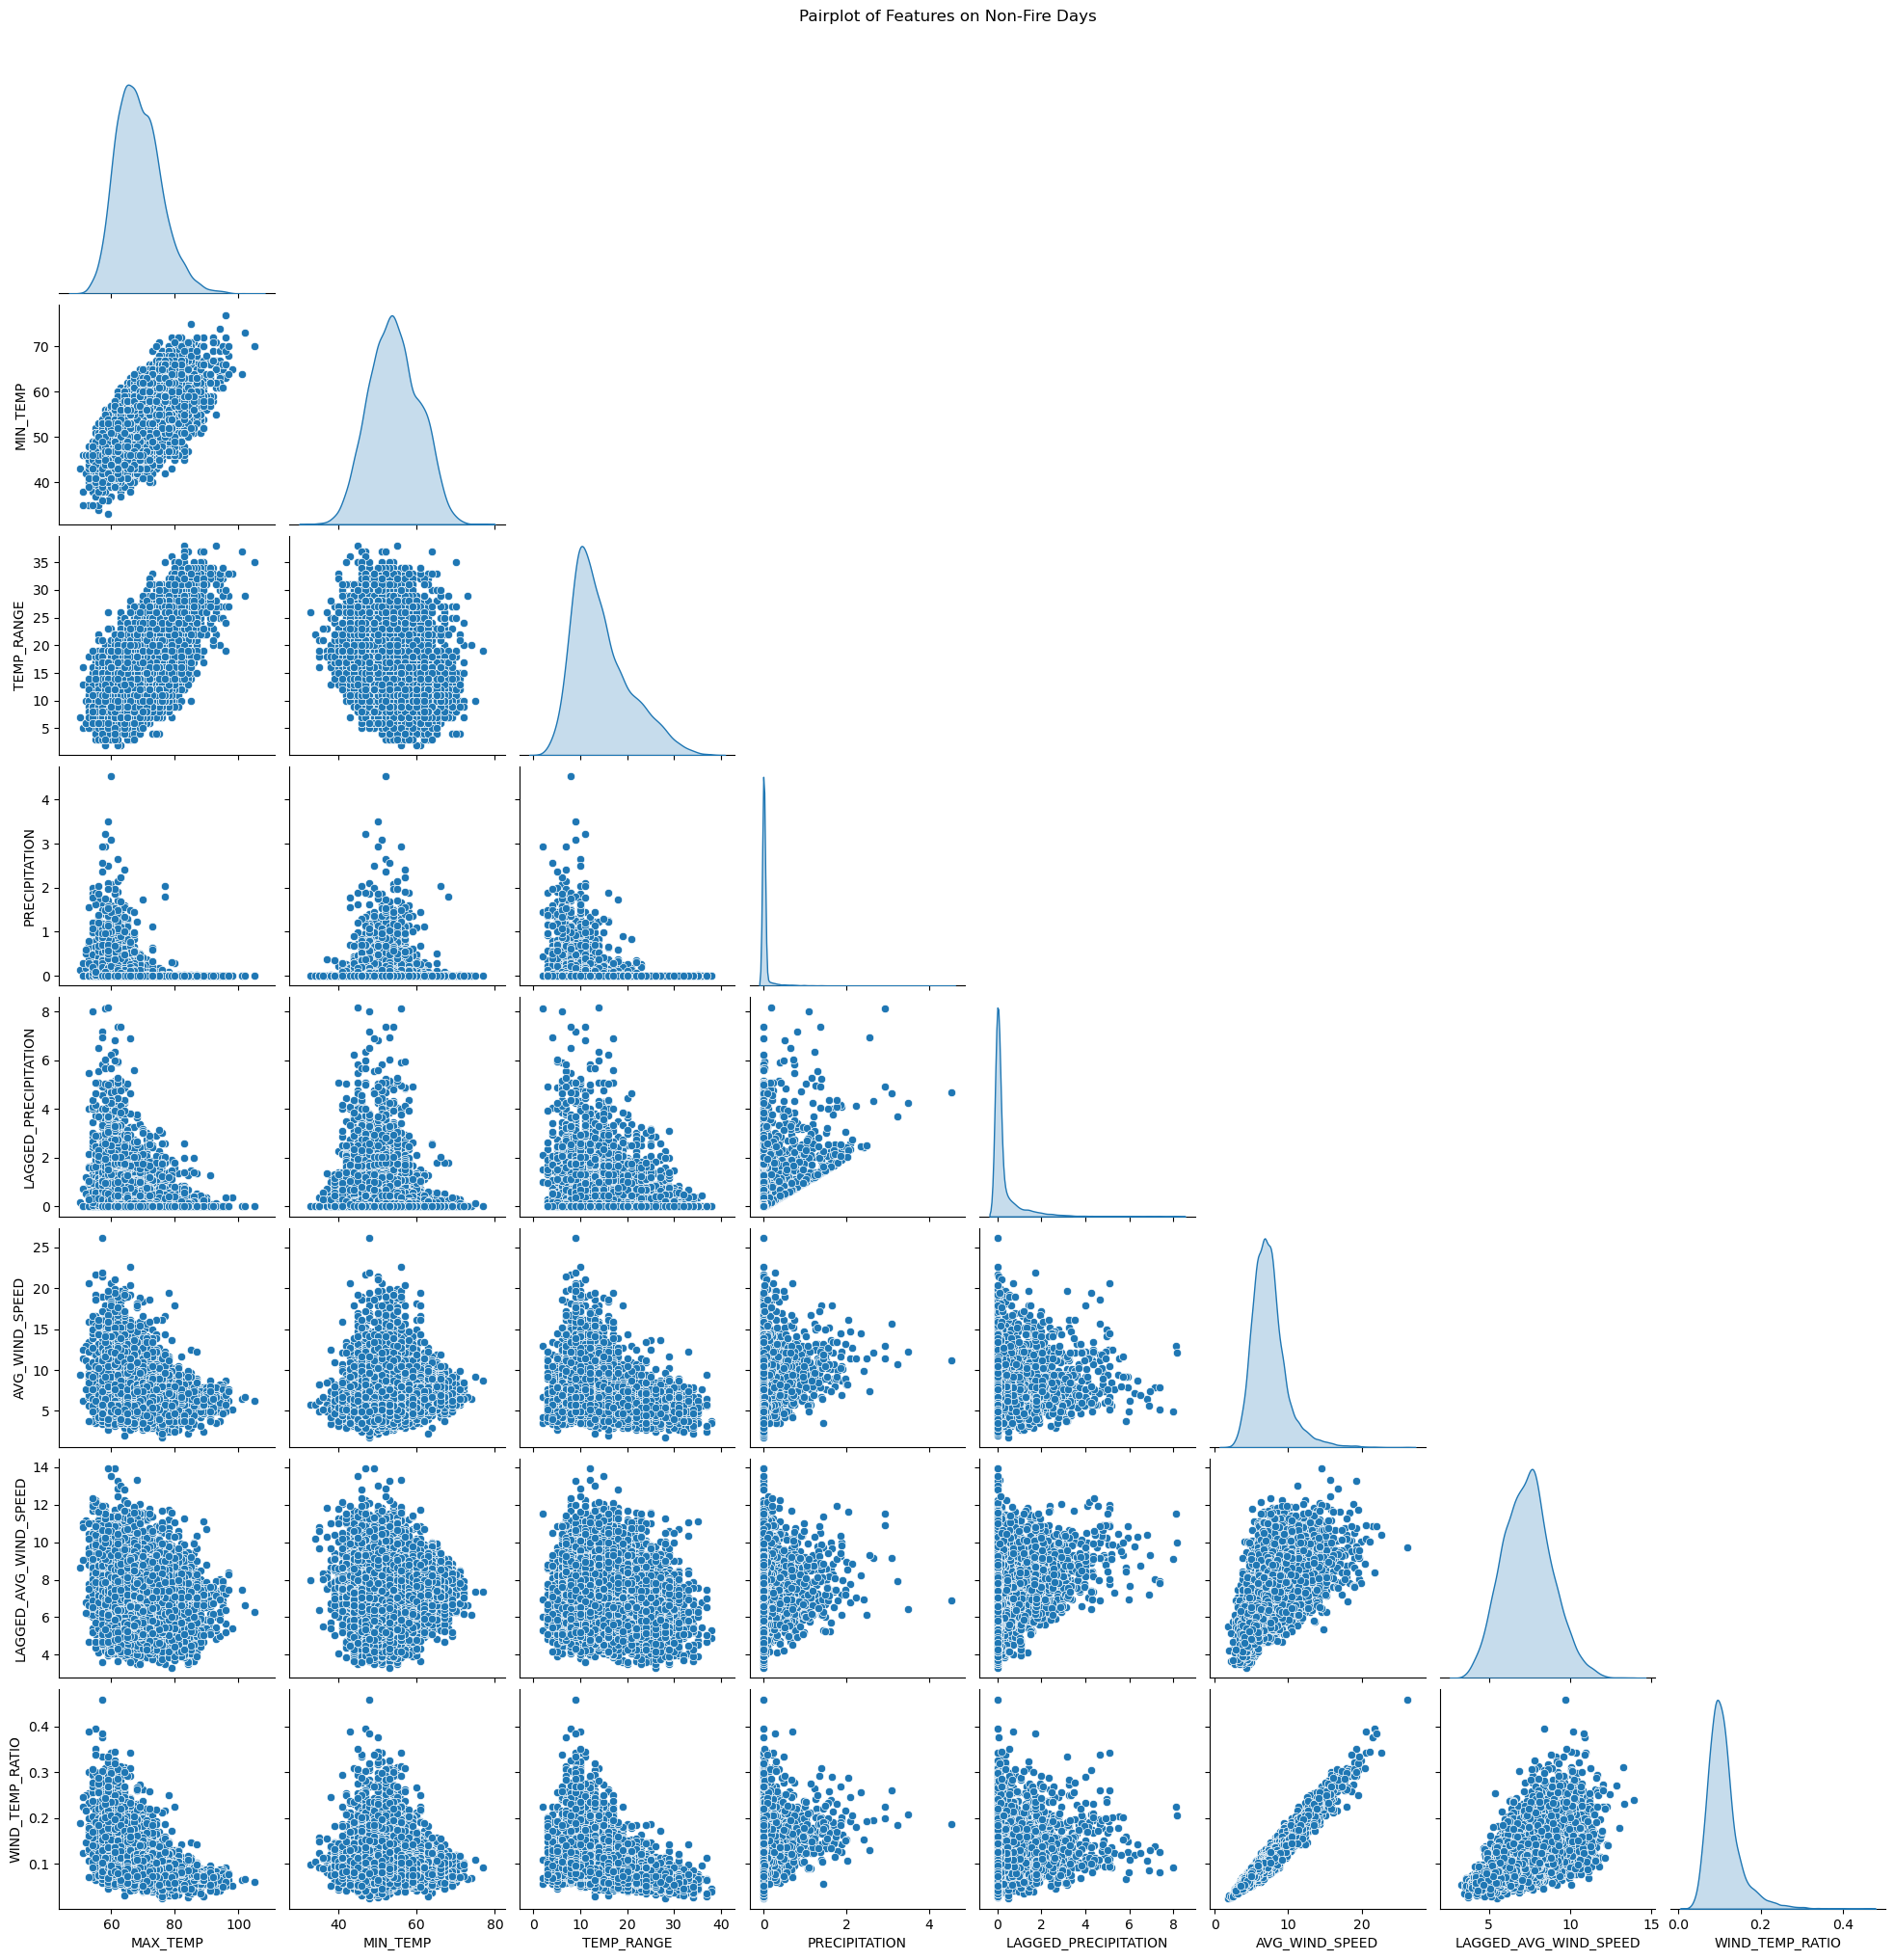

In [20]:
# Pairplot of features for non fire days
non_fire_days = df[df['FIRE_START_DAY'] == "False"]
sns.pairplot(non_fire_days[numerical_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Features on Non-Fire Days', y=1.02)
plt.show()

**Same analysis but if it roughly matches the fire-start day data, I won't mention it. So below is just the notable ones that are different. Meaning the pairs roughly similar are [MAX_TEMP & WIND_TEMP_RATIO, MAX_TEMP & MIN_TEMP, WIND_TEMP_RATIO & AVG_WIND_SPEED]** 

- **PRECIPITATION & MAX_TEMP**
    - Between 60 and 80, it is a vertical wall (kind of like a box) going up to 2 and then scattered at the top towards 3 and 4. But then after 80 in the x-axis, the points just lie at 0
    - This fits typical weather: hot days tend to be dry, which doesn't always mean fire-prone
- **PRECIPITATION & LAGGED PRECIPITATION**
    - Think of it like a square matrix with. There is a diagonal linear line increasing as it goes to the right. Everything below this line is empty, not even an outlier. Above this line, the points are kind of like a cone, with more points towards the begininning of the x-axis and then it fans out and upwards (this is above the diagonal still)
    - The empty area below diagonal reflects that the daily rain never exceeds weekly total which makes total sense
    - The cone/fan shape above means on days with low weekly precipitation, daily precipitation varies a lot; when weekly precipitation is higher, daily tends to be higher too
    - Shows how precipitation accumulates over the week — on non-fire days, rainfall is often consistent.
- **AVG_WIND_SPEED & LAGGED_AVG_WIND_SPEED**
    - Starts narrow and then fans out as it goes to the right and up, but the points are more condensed together
    - Non-fire days tend to have more stable and moderate wind conditions compared to fire days, which helps explain why fires are less likely
- **TEMP_RANGE & WIND_TEMP_RATIO**
    - Looks like a rough lower triangular matrix where the y-points are more with a low temp range and then y decreases as temp range increases
    - On non-fire days, when temperature swings (temp range) are low, wind-temp ratio (wind relative to temp) can be quite variable
    - This ***CONTRASTS*** fire days, where big temperature swings and strong winds happen together, which helps dry out plants and spread fires

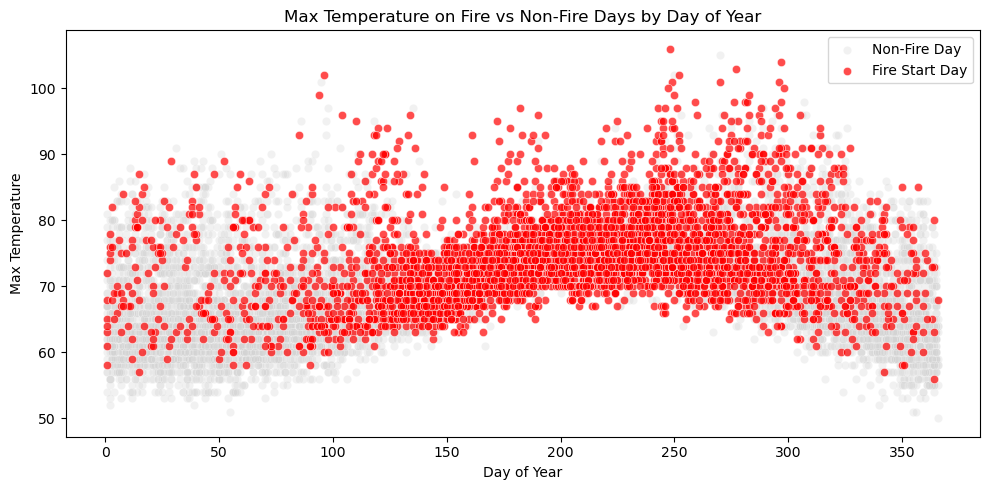

In [21]:
# Max temperature comparison

plt.figure(figsize=(10, 5))

# Non-fire = light gray
sns.scatterplot(data=non_fire_days, x='DAY_OF_YEAR', y='MAX_TEMP', 
                color='lightgray', label='Non-Fire Day', alpha=0.3)

# Fire = red
sns.scatterplot(data=fire_days, x='DAY_OF_YEAR', y='MAX_TEMP', 
                color='red', label='Fire Start Day', alpha=0.7)

plt.title('Max Temperature on Fire vs Non-Fire Days by Day of Year')
plt.xlabel('Day of Year')
plt.ylabel('Max Temperature')
plt.legend()
plt.tight_layout()
plt.show()



This plot shows us that fire start days do not always have to have extremely high temperatures. Fires can start even when the temperature feels cooler. And that in hotter months (starting in April and going to October), there are no fires in the cooler ranges (50s to high 60s).

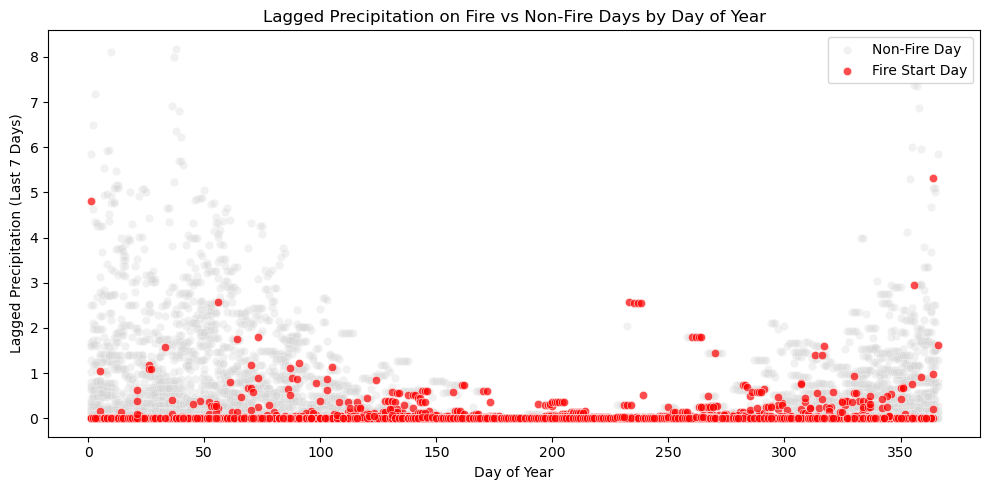

In [22]:
# Lagged precipitation (week) comparison

plt.figure(figsize=(10, 5))

sns.scatterplot(data=non_fire_days, x='DAY_OF_YEAR', y='LAGGED_PRECIPITATION',
                color='lightgray', label='Non-Fire Day', alpha=0.3)

sns.scatterplot(data=fire_days, x='DAY_OF_YEAR', y='LAGGED_PRECIPITATION',
                color='red', label='Fire Start Day', alpha=0.7)

plt.title('Lagged Precipitation on Fire vs Non-Fire Days by Day of Year')
plt.xlabel('Day of Year')
plt.ylabel('Lagged Precipitation (Last 7 Days)')
plt.legend()
plt.tight_layout()
plt.show()

This plot says that on fire start days, there is usually low to no precipitation/moisture but some fires (the rare cases) can also start on days with higher moisture. On non-fire start days, there is usually more rain-fall or moisture present in the air in the non-hot months (June to September). There is a sort of bowl shape showing this pattern.

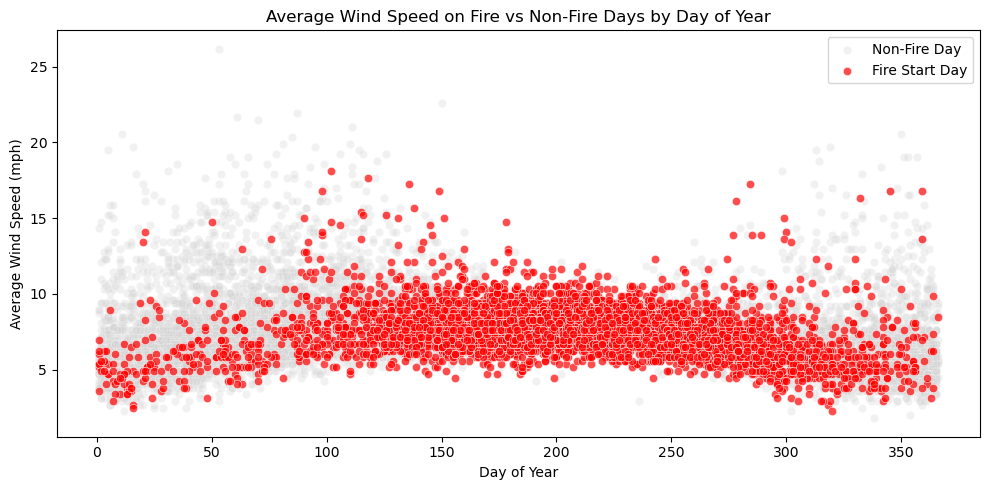

In [23]:
# Average wind speed comparison

plt.figure(figsize=(10, 5))

sns.scatterplot(data=non_fire_days, x='DAY_OF_YEAR', y='AVG_WIND_SPEED',
                color='lightgray', label='Non-Fire Day', alpha=0.3)

sns.scatterplot(data=fire_days, x='DAY_OF_YEAR', y='AVG_WIND_SPEED',
                color='red', label='Fire Start Day', alpha=0.7)

plt.title('Average Wind Speed on Fire vs Non-Fire Days by Day of Year')
plt.xlabel('Day of Year')
plt.ylabel('Average Wind Speed (mph)')
plt.legend()
plt.tight_layout()
plt.show()

This plot says that fires will usually start when there are moderate to high wind speeds but there are some exceptions where fires do start when there is low to no wind. Something notable that we see here again is that bowl shape in the hotter months (June to September) where no fires start at lower wind speeds. In the other months, there is also no usually fires that start.

## **Data Cleaning and Preparation for Machine Learning (LSTM)**

**DataFrame BEFORE Cleaning**

In [21]:
# Before windowing

print(df['FIRE_START_DAY'].value_counts())

False    10017
True      4971
Name: FIRE_START_DAY, dtype: int64


In [22]:
df.head(5)

DATE  PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED FIRE_START_DAY  \
0  1/1/84            0.0      79.0      51.0            4.70          False   
1  1/2/84            0.0      71.0      46.0            5.59          False   
2  1/3/84            0.0      70.0      47.0            5.37          False   
3  1/4/84            0.0      76.0      45.0            4.70          False   
4  1/5/84            0.0      74.0      49.0            5.14          False   

   YEAR  TEMP_RANGE  WIND_TEMP_RATIO  MONTH  SEASON  LAGGED_PRECIPITATION  \
0  1984        28.0         0.059494      1  Winter                   0.0   
1  1984        25.0         0.078732      1  Winter                   0.0   
2  1984        23.0         0.076714      1  Winter                   0.0   
3  1984        31.0         0.061842      1  Winter                   0.0   
4  1984        25.0         0.069459      1  Winter                   0.0   

   LAGGED_AVG_WIND_SPEED  DAY_OF_YEAR  
0                  4.700            1  
1                  5.145            2  
2                  5.220            3  
3                  5.090            4  
4                  5.100            5

**Handle Missing Values**

In [23]:
df.isnull().sum()

DATE                      0
PRECIPITATION             1
MAX_TEMP                  1
MIN_TEMP                  1
AVG_WIND_SPEED           12
FIRE_START_DAY            0
YEAR                      0
TEMP_RANGE                1
WIND_TEMP_RATIO          12
MONTH                     0
SEASON                    0
LAGGED_PRECIPITATION      0
LAGGED_AVG_WIND_SPEED     0
DAY_OF_YEAR               0
dtype: int64

Here we have the choice of just removing the rows with missing values or imputing. I would like to impute because these rows could be the rows that are the outliers and in our case, we'd want to keep the outliers and extreme conditions so our model can learn from them. Plus, there aren't a lot of extreme values our model can learn from so it would be beneficial information to keep. For numerical features, we can fill it with mean/median depending on the distribution of the data. There are no missing categorical data so that's fine.

In [24]:
# See row with missing information
missing_precipitation = df[df['PRECIPITATION'].isnull()]
missing_precipitation

DATE  PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  \
14975  12/31/24            NaN       NaN       NaN             NaN   

      FIRE_START_DAY  YEAR  TEMP_RANGE  WIND_TEMP_RATIO  MONTH  SEASON  \
14975          False  2024         NaN              NaN     12  Winter   

       LAGGED_PRECIPITATION  LAGGED_AVG_WIND_SPEED  DAY_OF_YEAR  
14975                   0.0                   4.92          366

In [26]:
# Impute based on disribution 

# Precipitation: impute zeros
df['PRECIPITATION'].fillna(0, inplace=True) 
# This makes sense because lagged precipitation for the week is 0, anyways

# For normally distributed features, use mean
for col in ['MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'WIND_TEMP_RATIO']:
    df[col].fillna(df[col].mean(), inplace=True)

# For skewed feature, use median (temp range is right-skewed)
df['TEMP_RANGE'].fillna(df['TEMP_RANGE'].median(), inplace=True)

**Encode Boolean and Categorical Variables**

For this part, we can either encode using **one-hot**, **label**, or **cyclical**. For LSTM, we should use cyclical because LSTMs learn patterns over sequences. Using cyclical encoding, the LSTM sees the cyclical features as smooth, continuous cycles, not broken numeric jumps. 
- This helps the model understand that after day 365, day 1 follows, or that Fall loops back to Winter.
- This prevents the model from learning incorrect discontinuities in time-based data.

In [29]:
# Encode target variable boolean

df['FIRE_START_DAY'] = df['FIRE_START_DAY'].map({'False': 0, 'True': 1}).astype(int)

In [31]:
# Cyclical encoding for SEASON
season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
df['SEASON_NUM'] = df['SEASON'].map(season_mapping)
df['SEASON_SIN'] = np.sin(2 * np.pi * df['SEASON_NUM'] / 4)
df['SEASON_COS'] = np.cos(2 * np.pi * df['SEASON_NUM'] / 4)
df = df.drop(columns=['SEASON', 'SEASON_NUM'])

# Cyclical encoding for DAY_OF_YEAR
max_day = 366
df['DAY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_YEAR'] / max_day)
df['DAY_COS'] = np.cos(2 * np.pi * df['DAY_OF_YEAR'] / max_day)
df = df.drop(columns=['DAY_OF_YEAR'])

**Move Target Variable to the End**

In [32]:
# Move 'FIRE_START_DAY' to the end
cols = [col for col in df.columns if col != 'FIRE_START_DAY'] + ['FIRE_START_DAY']
df = df[cols]

**Clean and Format Date**

In [33]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')

**Drop Redundant/Unneeded Features**

To help identify redundant and unneeded features, we can use a correlation matrix and anything that has a high correlation r-value, we can take one out.

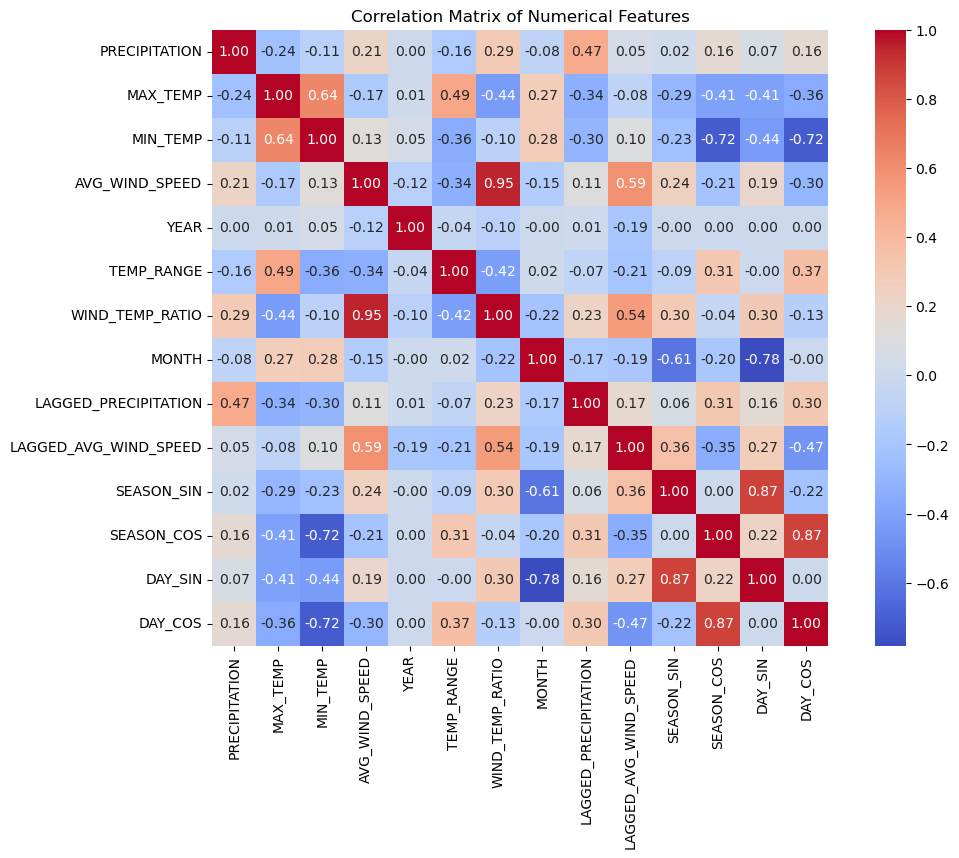

In [35]:
# Correlation of numerical feaetures

numeric_cols = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'YEAR', 'TEMP_RANGE', 'WIND_TEMP_RATIO', 'MONTH',
    'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'SEASON_SIN', "SEASON_COS", "DAY_SIN", "DAY_COS"]

plt.figure(figsize=(12, 8))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [36]:
# List out the strong correlation pairs

corr_matrix = df[numeric_cols].corr().abs()

# This is to avoid duplicates (select just the upper triangle of the matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation >= 0.5 (can adjust this threshold if needed)
strong_corrs = upper.stack().reset_index()
strong_corrs.columns = ['Feature 1', 'Feature 2', 'Correlation']
strong_corrs = strong_corrs[strong_corrs['Correlation'] >= 0.5]
strong_corrs = strong_corrs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

print(strong_corrs)

         Feature 1              Feature 2  Correlation
0   AVG_WIND_SPEED        WIND_TEMP_RATIO     0.950775
1       SEASON_SIN                DAY_SIN     0.872466
2       SEASON_COS                DAY_COS     0.872159
3            MONTH                DAY_SIN     0.782334
4         MIN_TEMP             SEASON_COS     0.717137
5         MIN_TEMP                DAY_COS     0.715650
6         MAX_TEMP               MIN_TEMP     0.636894
7            MONTH             SEASON_SIN     0.614545
8   AVG_WIND_SPEED  LAGGED_AVG_WIND_SPEED     0.594199
9  WIND_TEMP_RATIO  LAGGED_AVG_WIND_SPEED     0.544005


Multicollinearity can prove to be an issue depending on the models that will be used in this pipeline. Logistic regression is very sensitive to multicollinearity so ideally, we would want to address this by either getting rid of or combining the features that are highly correlated (> 0.8). LSTM is more robust to multicollinearity, but it is still good to take out a feature to avoid redundancy. It makes sense that these values are correlated because day of year corresponds to the month, average wind speeds depend on the wind that day, higher max temperatures usually also mean higher minimum temperatures, etc. So we will address this issue of multicollinearity later during pre-processing and feature engineering.

In [37]:
# Drop the features. We can mess around with wind temp ratio later to see if it is helpful to our data

df = df.drop(columns=['MONTH', 'DATE', 'WIND_TEMP_RATIO']) 

In [38]:
df.columns

Index(['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'YEAR',
       'TEMP_RANGE', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED',
       'SEASON_SIN', 'SEASON_COS', 'DAY_SIN', 'DAY_COS', 'FIRE_START_DAY'],
      dtype='object')

**Rescale/Normalize**

For LSTM, we should Normalize our data.

In [39]:
# Features to normalize (exclude cyclical sin/cos and target)
to_normalize = [
    'PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
    'YEAR', 'TEMP_RANGE', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED']

scaler = MinMaxScaler()
df[to_normalize] = scaler.fit_transform(df[to_normalize])

**DataFrame AFTER Cleaning**

In [40]:
df.head(5)

PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  YEAR  TEMP_RANGE  \
0            0.0  0.517857  0.409091        0.119360   0.0    0.666667   
1            0.0  0.375000  0.295455        0.155865   0.0    0.589744   
2            0.0  0.357143  0.318182        0.146842   0.0    0.538462   
3            0.0  0.464286  0.272727        0.119360   0.0    0.743590   
4            0.0  0.428571  0.363636        0.137408   0.0    0.589744   

   LAGGED_PRECIPITATION  LAGGED_AVG_WIND_SPEED  SEASON_SIN  SEASON_COS  \
0                   0.0               0.137577         0.0         1.0   
1                   0.0               0.179143         0.0         1.0   
2                   0.0               0.186149         0.0         1.0   
3                   0.0               0.174006         0.0         1.0   
4                   0.0               0.174940         0.0         1.0   

    DAY_SIN   DAY_COS  FIRE_START_DAY  
0  0.017166  0.999853               0  
1  0.034328  0.999411               0  
2  0.051479  0.998674               0  
3  0.068615  0.997643               0  
4  0.085731  0.996318               0

In [ ]:
# SAVE DATAFRAME

df.to_csv('firedf_cleaned.csv', index=False)

# ***MACHINE LEARNING***

## **Problem Formulation**

**Remove unneed columns, for example:**
- **duplicated**
- **categorical features that were turned into one-hot**
- **features that identify specific rows, like ID number**
- **make sure your target is properly encoded also**

In [ ]:
df = pd.read_csv("/Users/marielle/Desktop/firedf_cleaned.csv")

In [41]:
# Check duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [43]:
# Before windowing

print(df['FIRE_START_DAY'].value_counts())

0    10017
1     4971
Name: FIRE_START_DAY, dtype: int64


Everything else seems pretty good and addressed during the data cleaning part. 

## **Train ML Algorithm: LSTM (30 DAY WINDOW)**

**Extracting Features and Creating Windows: 30-DAY TIME PERIOD, CAN CHANGE IF WANT TO**

In [44]:
# Your features and target columns (scaled features + cyclical features, target)
feature_cols = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'TEMP_RANGE',
    'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'YEAR', 'SEASON_SIN', 'SEASON_COS', 'DAY_SIN',
    'DAY_COS',]
target_col = 'FIRE_START_DAY'

# Extract features and target arrays
features = df[feature_cols].values
target = df[target_col].values

# Sequence window size (30 days) - Can change if you want to to maybe 14 days before
window_size = 30

def create_sequences(features, labels, window=30):
    X, y = [], []
    for i in range(len(features) - window):
        X.append(features[i:i+window])
        y.append(labels[i+window])
    return np.array(X), np.array(y)

# Create sequences and labels
X, y = create_sequences(features, target, window=window_size)

print(f"Total samples: {X.shape[0]}, Sequence length: {X.shape[1]}, Features per timestep: {X.shape[2]}")

Total samples: 14958, Sequence length: 30, Features per timestep: 12


**Split training sample into train, validation, and test sub-samples**

In [45]:
# Split into train (70%), validation (15%), test (15%)
num_samples = len(X)
train_end = int(0.7 * num_samples)
val_end = int(0.85 * num_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"Train samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Train samples: 10470
Validation samples: 2244
Test samples: 2244


**Build the LSTM Model**

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.utils import class_weight

# Define input shape
timesteps = X_train.shape[1]   # e.g. 30
n_features = X_train.shape[2]  # e.g. 12

# Calculate class weights to handle imbalance
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(weights))
print("Class weights:", class_weight_dict)

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(timesteps, n_features), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # for binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Class weights: {0: 0.7195876288659794, 1: 1.6384976525821595}


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

**Train Model with Class Weight**

In [47]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=2)

Epoch 1/20
164/164 - 2s - 12ms/step - accuracy: 0.7448 - loss: 0.5255 - val_accuracy: 0.7389 - val_loss: 0.5363
Epoch 2/20
164/164 - 1s - 7ms/step - accuracy: 0.7528 - loss: 0.5060 - val_accuracy: 0.7447 - val_loss: 0.5271
Epoch 3/20
164/164 - 1s - 7ms/step - accuracy: 0.7588 - loss: 0.4973 - val_accuracy: 0.7406 - val_loss: 0.5648
Epoch 4/20
164/164 - 1s - 7ms/step - accuracy: 0.7555 - loss: 0.4948 - val_accuracy: 0.7518 - val_loss: 0.5323
Epoch 5/20
164/164 - 1s - 7ms/step - accuracy: 0.7537 - loss: 0.4932 - val_accuracy: 0.7237 - val_loss: 0.5716
Epoch 6/20
164/164 - 1s - 7ms/step - accuracy: 0.7618 - loss: 0.4880 - val_accuracy: 0.7491 - val_loss: 0.5436
Epoch 7/20
164/164 - 1s - 7ms/step - accuracy: 0.7610 - loss: 0.4906 - val_accuracy: 0.7206 - val_loss: 0.5656
Epoch 8/20
164/164 - 1s - 7ms/step - accuracy: 0.7609 - loss: 0.4854 - val_accuracy: 0.7353 - val_loss: 0.5658
Epoch 9/20
164/164 - 1s - 7ms/step - accuracy: 0.7609 - loss: 0.4833 - val_accuracy: 0.7317 - val_loss: 0.5427


## **Evaluate Performance on Validation Set**

In [48]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Predict probabilities
y_val_probs = model.predict(X_val).flatten()
y_val_preds = (y_val_probs >= 0.5).astype(int)  # threshold at 0.5

# Classification report (Precision, Recall, F1)
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_preds))

# ROC-AUC score
roc = roc_auc_score(y_val, y_val_probs)
print(f"Validation ROC-AUC Score: {roc:.4f}")

# Optional: confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.64      0.73      1279
           1       0.64      0.85      0.73       965

    accuracy                           0.73      2244
   macro avg       0.75      0.75      0.73      2244
weighted avg       0.76      0.73      0.73      2244

Validation ROC-AUC Score: 0.8288
Confusion Matrix:
 [[820 459]
 [143 822]]


**Let's play around with different timeframes to see which one is better to use using the ROC-AUC curve as a reference (correctly identifying fire vs non-fire days)**

## **Trying It Out with a 14-Day Window**

In [50]:
window_size = 14  # new shorter window

def create_sequences(features, labels, window=window_size):
    X, y = [], []
    for i in range(len(features) - window):
        X.append(features[i:i+window])
        y.append(labels[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(features, target, window=window_size)

print(f"Total samples: {X.shape[0]}, Sequence length: {X.shape[1]}, Features per timestep: {X.shape[2]}")

Total samples: 14974, Sequence length: 14, Features per timestep: 12


In [51]:
num_samples = len(X)
train_end = int(0.7 * num_samples)
val_end = int(0.85 * num_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"Train samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Train samples: 10481
Validation samples: 2246
Test samples: 2247


In [52]:
timesteps = X_train.shape[1]   # now 14
n_features = X_train.shape[2]

# You can keep the same model architecture or tweak it if you want.
model = Sequential([
    LSTM(64, input_shape=(timesteps, n_features), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# Calculate class weights (same as before)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(weights))

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=2
)

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
164/164 - 2s - 10ms/step - accuracy: 0.7328 - loss: 0.5336 - val_accuracy: 0.7493 - val_loss: 0.5235
Epoch 2/20
164/164 - 1s - 4ms/step - accuracy: 0.7577 - loss: 0.5077 - val_accuracy: 0.7462 - val_loss: 0.5293
Epoch 3/20
164/164 - 1s - 4ms/step - accuracy: 0.7603 - loss: 0.5002 - val_accuracy: 0.7471 - val_loss: 0.5360
Epoch 4/20
164/164 - 1s - 4ms/step - accuracy: 0.7597 - loss: 0.4970 - val_accuracy: 0.7369 - val_loss: 0.5352
Epoch 5/20
164/164 - 1s - 4ms/step - accuracy: 0.7590 - loss: 0.4947 - val_accuracy: 0.7462 - val_loss: 0.5274
Epoch 6/20
164/164 - 1s - 5ms/step - accuracy: 0.7592 - loss: 0.4916 - val_accuracy: 0.7168 - val_loss: 0.5710
Epoch 7/20
164/164 - 1s - 5ms/step - accuracy: 0.7604 - loss: 0.4867 - val_accuracy: 0.7351 - val_loss: 0.5661
Epoch 8/20
164/164 - 1s - 5ms/step - accuracy: 0.7601 - loss: 0.4863 - val_accuracy: 0.7373 - val_loss: 0.5642
Epoch 9/20
164/164 - 1s - 4ms/step - accuracy: 0.7672 - loss: 0.4863 - val_accuracy: 0.7128 - val_loss: 0.5944


In [53]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_val_probs = model.predict(X_val).flatten()
y_val_preds = (y_val_probs >= 0.5).astype(int)

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_preds))

roc = roc_auc_score(y_val, y_val_probs)
print(f"Validation ROC-AUC Score: {roc:.4f}")

print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.61      0.71      1278
           1       0.62      0.86      0.72       968

    accuracy                           0.72      2246
   macro avg       0.74      0.73      0.71      2246
weighted avg       0.75      0.72      0.71      2246

Validation ROC-AUC Score: 0.8262
Confusion Matrix:
 [[776 502]
 [138 830]]


## **Trying It Out with a 21-Day Window**

In [54]:
window_size = 21  # Set window size to 21 days

def create_sequences(features, labels, window=window_size):
    X, y = [], []
    for i in range(len(features) - window):
        X.append(features[i:i+window])
        y.append(labels[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(features, target, window=window_size)

print(f"Total samples: {X.shape[0]}, Sequence length: {X.shape[1]}, Features per timestep: {X.shape[2]}")

# Split into train/val/test
num_samples = len(X)
train_end = int(0.7 * num_samples)
val_end = int(0.85 * num_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"Train samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Model input shape update
timesteps = X_train.shape[1]   # should be 21 now
n_features = X_train.shape[2]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.utils import class_weight

# Calculate class weights to handle imbalance
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(weights))

model = Sequential([
    LSTM(64, input_shape=(timesteps, n_features), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=2
)

# Evaluation on validation set
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_val_probs = model.predict(X_val).flatten()
y_val_preds = (y_val_probs >= 0.5).astype(int)

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_preds))

roc = roc_auc_score(y_val, y_val_probs)
print(f"Validation ROC-AUC Score: {roc:.4f}")

print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))

Total samples: 14967, Sequence length: 21, Features per timestep: 12
Train samples: 10476
Validation samples: 2245
Test samples: 2246


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
164/164 - 2s - 11ms/step - accuracy: 0.7360 - loss: 0.5334 - val_accuracy: 0.7421 - val_loss: 0.5297
Epoch 2/20
164/164 - 1s - 6ms/step - accuracy: 0.7570 - loss: 0.5057 - val_accuracy: 0.7381 - val_loss: 0.5574
Epoch 3/20
164/164 - 1s - 5ms/step - accuracy: 0.7576 - loss: 0.5002 - val_accuracy: 0.7367 - val_loss: 0.5457
Epoch 4/20
164/164 - 1s - 5ms/step - accuracy: 0.7592 - loss: 0.4935 - val_accuracy: 0.7563 - val_loss: 0.5242
Epoch 5/20
164/164 - 1s - 6ms/step - accuracy: 0.7597 - loss: 0.4913 - val_accuracy: 0.7278 - val_loss: 0.5676
Epoch 6/20
164/164 - 1s - 6ms/step - accuracy: 0.7573 - loss: 0.4919 - val_accuracy: 0.7238 - val_loss: 0.5728
Epoch 7/20
164/164 - 1s - 5ms/step - accuracy: 0.7576 - loss: 0.4889 - val_accuracy: 0.7229 - val_loss: 0.5549
Epoch 8/20
164/164 - 1s - 5ms/step - accuracy: 0.7607 - loss: 0.4868 - val_accuracy: 0.7367 - val_loss: 0.5655
Epoch 9/20
164/164 - 1s - 5ms/step - accuracy: 0.7616 - loss: 0.4866 - val_accuracy: 0.7403 - val_loss: 0.5545


**21 day window seems to be the best so we will use this window time-frame to improve our LSTM model**

## **Trying out 2 Improvements: Early Stopping and Threshold Tuning**

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop if no improvement after 5 epochs
    restore_best_weights=True  # keep best weights
)

In [56]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # increase max epochs to give early stopping room
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=2)

Epoch 1/50
164/164 - 1s - 6ms/step - accuracy: 0.7631 - loss: 0.4831 - val_accuracy: 0.7354 - val_loss: 0.5535
Epoch 2/50
164/164 - 1s - 7ms/step - accuracy: 0.7647 - loss: 0.4793 - val_accuracy: 0.7140 - val_loss: 0.5786
Epoch 3/50
164/164 - 1s - 5ms/step - accuracy: 0.7616 - loss: 0.4813 - val_accuracy: 0.7452 - val_loss: 0.5291
Epoch 4/50
164/164 - 1s - 6ms/step - accuracy: 0.7667 - loss: 0.4802 - val_accuracy: 0.7367 - val_loss: 0.5477
Epoch 5/50
164/164 - 1s - 5ms/step - accuracy: 0.7640 - loss: 0.4806 - val_accuracy: 0.7216 - val_loss: 0.6199
Epoch 6/50
164/164 - 1s - 5ms/step - accuracy: 0.7662 - loss: 0.4777 - val_accuracy: 0.7367 - val_loss: 0.5328
Epoch 7/50
164/164 - 1s - 5ms/step - accuracy: 0.7650 - loss: 0.4787 - val_accuracy: 0.7292 - val_loss: 0.5753
Epoch 8/50
164/164 - 1s - 5ms/step - accuracy: 0.7658 - loss: 0.4786 - val_accuracy: 0.7212 - val_loss: 0.5680


In [57]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities on validation set
y_val_probs = model.predict(X_val).flatten()

# Calculate precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Find threshold that gives max F1
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold for max F1: {best_threshold:.3f}")

# Predict with best threshold
y_val_preds = (y_val_probs >= best_threshold).astype(int)

# Show classification report with best threshold
print("\nValidation Classification Report (best threshold):")
print(classification_report(y_val, y_val_preds))

roc = roc_auc_score(y_val, y_val_probs)
print(f"Validation ROC-AUC Score: {roc:.4f}")

print("Confusion Matrix (best threshold):\n", confusion_matrix(y_val, y_val_preds))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold for max F1: 0.500

Validation Classification Report (best threshold):
              precision    recall  f1-score   support

           0       0.83      0.69      0.76      1278
           1       0.67      0.82      0.73       967

    accuracy                           0.75      2245
   macro avg       0.75      0.75      0.74      2245
weighted avg       0.76      0.75      0.75      2245

Validation ROC-AUC Score: 0.8295
Confusion Matrix (best threshold):
 [[884 394]
 [178 789]]


**This increased our performance and we found that the best threshold to maximize F1 is 0.5. However, we want to maximize recall as failing to identify a fire can be detrimental**

## **Trying More**

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score

# Focal loss implementation
import tensorflow.keras.backend as K
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss)
    return focal_loss_fixed

# Build Bidirectional LSTM model function
def build_bi_lstm_model(timesteps, n_features, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, return_sequences=False), input_shape=(timesteps, n_features)),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss=focal_loss(gamma=2., alpha=0.25), optimizer='adam', metrics=['accuracy'])
    return model

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Hyperparameter grid to try
params = [
    {'lstm_units': 32, 'dropout_rate': 0.2},
    {'lstm_units': 64, 'dropout_rate': 0.3},
    {'lstm_units': 128, 'dropout_rate': 0.4},
]

best_val_f1 = 0
best_model = None
best_params = None

for p in params:
    print(f"\nTraining with params: {p}")
    model = build_bi_lstm_model(timesteps, n_features, **p)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=64,
        verbose=2
    )
    
    # Predict on validation set
    y_val_probs = model.predict(X_val).flatten()
    y_val_preds = (y_val_probs >= 0.5).astype(int)
    
    val_f1 = f1_score(y_val, y_val_preds)
    print(f"Validation F1-score: {val_f1:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model = model
        best_params = p

print(f"\nBest params: {best_params} with Validation F1: {best_val_f1:.4f}")

# Final evaluation on validation set using best model
y_val_probs = best_model.predict(X_val).flatten()
y_val_preds = (y_val_probs >= 0.5).astype(int)

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_preds))

roc_auc = roc_auc_score(y_val, y_val_probs)
print(f"Validation ROC-AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_preds))



Training with params: {'lstm_units': 32, 'dropout_rate': 0.2}
Epoch 1/15


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 2s - 13ms/step - accuracy: 0.7782 - loss: 0.0308 - val_accuracy: 0.7528 - val_loss: 0.0340
Epoch 2/15
164/164 - 1s - 6ms/step - accuracy: 0.7844 - loss: 0.0294 - val_accuracy: 0.7599 - val_loss: 0.0328
Epoch 3/15
164/164 - 1s - 6ms/step - accuracy: 0.7869 - loss: 0.0294 - val_accuracy: 0.7586 - val_loss: 0.0329
Epoch 4/15
164/164 - 1s - 6ms/step - accuracy: 0.7878 - loss: 0.0290 - val_accuracy: 0.7568 - val_loss: 0.0324
Epoch 5/15
164/164 - 1s - 7ms/step - accuracy: 0.7898 - loss: 0.0287 - val_accuracy: 0.7604 - val_loss: 0.0324
Epoch 6/15
164/164 - 1s - 7ms/step - accuracy: 0.7876 - loss: 0.0286 - val_accuracy: 0.7626 - val_loss: 0.0325
Epoch 7/15
164/164 - 1s - 6ms/step - accuracy: 0.7880 - loss: 0.0286 - val_accuracy: 0.7595 - val_loss: 0.0326
Epoch 8/15
164/164 - 1s - 5ms/step - accuracy: 0.7868 - loss: 0.0284 - val_accuracy: 0.7621 - val_loss: 0.0324
Epoch 9/15
164/164 - 1s - 5ms/step - accuracy: 0.7874 - loss: 0.0285 - val_accuracy: 0.7604 - val_loss: 0.0330
Epoch 10/15

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 2s - 15ms/step - accuracy: 0.7764 - loss: 0.0306 - val_accuracy: 0.7532 - val_loss: 0.0340
Epoch 2/15
164/164 - 2s - 10ms/step - accuracy: 0.7848 - loss: 0.0293 - val_accuracy: 0.7586 - val_loss: 0.0326
Epoch 3/15
164/164 - 2s - 10ms/step - accuracy: 0.7818 - loss: 0.0292 - val_accuracy: 0.7604 - val_loss: 0.0324
Epoch 4/15
164/164 - 2s - 10ms/step - accuracy: 0.7882 - loss: 0.0289 - val_accuracy: 0.7626 - val_loss: 0.0324
Epoch 5/15
164/164 - 2s - 11ms/step - accuracy: 0.7860 - loss: 0.0287 - val_accuracy: 0.7626 - val_loss: 0.0327
Epoch 6/15
164/164 - 2s - 10ms/step - accuracy: 0.7883 - loss: 0.0287 - val_accuracy: 0.7639 - val_loss: 0.0325
Epoch 7/15
164/164 - 2s - 10ms/step - accuracy: 0.7891 - loss: 0.0284 - val_accuracy: 0.7537 - val_loss: 0.0325
Epoch 8/15
164/164 - 2s - 10ms/step - accuracy: 0.7844 - loss: 0.0286 - val_accuracy: 0.7617 - val_loss: 0.0327
Epoch 9/15
164/164 - 2s - 10ms/step - accuracy: 0.7877 - loss: 0.0285 - val_accuracy: 0.7541 - val_loss: 0.0330
Epo

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 5s - 30ms/step - accuracy: 0.7784 - loss: 0.0303 - val_accuracy: 0.7604 - val_loss: 0.0327
Epoch 2/15
164/164 - 5s - 28ms/step - accuracy: 0.7823 - loss: 0.0294 - val_accuracy: 0.7550 - val_loss: 0.0332
Epoch 3/15
164/164 - 4s - 27ms/step - accuracy: 0.7847 - loss: 0.0291 - val_accuracy: 0.7568 - val_loss: 0.0330
Epoch 4/15
164/164 - 4s - 27ms/step - accuracy: 0.7831 - loss: 0.0289 - val_accuracy: 0.7612 - val_loss: 0.0333
Epoch 5/15
164/164 - 4s - 27ms/step - accuracy: 0.7877 - loss: 0.0286 - val_accuracy: 0.7661 - val_loss: 0.0327
Epoch 6/15
164/164 - 5s - 28ms/step - accuracy: 0.7843 - loss: 0.0284 - val_accuracy: 0.7679 - val_loss: 0.0327
Epoch 7/15
164/164 - 5s - 29ms/step - accuracy: 0.7872 - loss: 0.0286 - val_accuracy: 0.7581 - val_loss: 0.0327
Epoch 8/15
164/164 - 5s - 29ms/step - accuracy: 0.7877 - loss: 0.0286 - val_accuracy: 0.7550 - val_loss: 0.0332
Epoch 9/15
164/164 - 5s - 28ms/step - accuracy: 0.7877 - loss: 0.0287 - val_accuracy: 0.7608 - val_loss: 0.0327
Epo

## **Finding the Best Threshold**

In [59]:
import numpy as np
from sklearn.metrics import f1_score

# y_val_probs from your model.predict(X_val), probabilities

thresholds = np.arange(0.1, 0.91, 0.01)
best_threshold = 0.5
best_f1 = 0

for thresh in thresholds:
    preds = (y_val_probs >= thresh).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")

# Evaluate final with best threshold
best_preds = (y_val_probs >= best_threshold).astype(int)

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("\nClassification Report (Best Threshold):")
print(classification_report(y_val, best_preds))

roc_auc = roc_auc_score(y_val, y_val_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_val, best_preds))

Best threshold: 0.48 with F1-score: 0.7369

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1278
           1       0.69      0.79      0.74       967

    accuracy                           0.76      2245
   macro avg       0.76      0.76      0.76      2245
weighted avg       0.76      0.76      0.76      2245

ROC-AUC Score: 0.8303
Confusion Matrix:
[[932 346]
 [201 766]]


## **Maximizing Recall and Trying Other Architectures**

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional

def build_model(arch, timesteps, n_features):
    model = Sequential()
    
    if arch == 'lstm':
        model.add(LSTM(64, input_shape=(timesteps, n_features)))
    elif arch == 'gru':
        model.add(GRU(64, input_shape=(timesteps, n_features)))
    elif arch == 'stacked_lstm':
        model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, n_features)))
        model.add(LSTM(32))
    elif arch == 'cnn_lstm':
        model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(64))
    elif arch == 'bi_lstm':
        model.add(Bidirectional(LSTM(64), input_shape=(timesteps, n_features)))
    else:
        raise ValueError("Unknown architecture")

    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

import numpy as np
from sklearn.metrics import recall_score

# Train and evaluate each architecture
architectures = ['lstm', 'gru', 'stacked_lstm', 'cnn_lstm', 'bi_lstm']

best_recall = 0
best_arch = None
best_model = None
best_threshold = 0.5

for arch in architectures:
    print(f"\nTraining model: {arch}")
    model = build_model(arch, timesteps, n_features)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=64, verbose=2)
    
    y_val_probs = model.predict(X_val).flatten()
    
    # Find threshold maximizing recall
    thresholds = np.arange(0.1, 1.0, 0.01)
    recalls = []
    for t in thresholds:
        y_val_preds = (y_val_probs >= t).astype(int)
        recalls.append(recall_score(y_val, y_val_preds))
    max_recall_idx = np.argmax(recalls)
    best_t_for_arch = thresholds[max_recall_idx]
    max_recall_for_arch = recalls[max_recall_idx]
    
    print(f"Best threshold for recall: {best_t_for_arch:.2f} with recall: {max_recall_for_arch:.4f}")
    
    if max_recall_for_arch > best_recall:
        best_recall = max_recall_for_arch
        best_arch = arch
        best_model = model
        best_threshold = best_t_for_arch

print(f"\nBest architecture: {best_arch} with recall: {best_recall:.4f} at threshold {best_threshold:.2f}")

# Evaluate best model
y_val_probs = best_model.predict(X_val).flatten()
y_val_preds = (y_val_probs >= best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\nClassification Report (best model and threshold):")
print(classification_report(y_val, y_val_preds))
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_probs):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_preds))


Training model: lstm
Epoch 1/15


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 2s - 12ms/step - accuracy: 0.7774 - loss: 0.4771 - val_accuracy: 0.7635 - val_loss: 0.5153
Epoch 2/15
164/164 - 1s - 6ms/step - accuracy: 0.7860 - loss: 0.4584 - val_accuracy: 0.7626 - val_loss: 0.5074
Epoch 3/15
164/164 - 1s - 6ms/step - accuracy: 0.7855 - loss: 0.4522 - val_accuracy: 0.7425 - val_loss: 0.5172
Epoch 4/15
164/164 - 1s - 6ms/step - accuracy: 0.7854 - loss: 0.4472 - val_accuracy: 0.7617 - val_loss: 0.5051
Epoch 5/15
164/164 - 1s - 6ms/step - accuracy: 0.7865 - loss: 0.4456 - val_accuracy: 0.7604 - val_loss: 0.5089
Epoch 6/15
164/164 - 1s - 7ms/step - accuracy: 0.7897 - loss: 0.4445 - val_accuracy: 0.7644 - val_loss: 0.5050
Epoch 7/15
164/164 - 1s - 6ms/step - accuracy: 0.7884 - loss: 0.4418 - val_accuracy: 0.7537 - val_loss: 0.5147
Epoch 8/15
164/164 - 1s - 7ms/step - accuracy: 0.7865 - loss: 0.4434 - val_accuracy: 0.7621 - val_loss: 0.5080
Epoch 9/15
164/164 - 1s - 6ms/step - accuracy: 0.7871 - loss: 0.4399 - val_accuracy: 0.7595 - val_loss: 0.5086
Epoch 10/15

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 2s - 12ms/step - accuracy: 0.7729 - loss: 0.4848 - val_accuracy: 0.7572 - val_loss: 0.5226
Epoch 2/15
164/164 - 1s - 7ms/step - accuracy: 0.7828 - loss: 0.4573 - val_accuracy: 0.7586 - val_loss: 0.5152
Epoch 3/15
164/164 - 1s - 7ms/step - accuracy: 0.7856 - loss: 0.4462 - val_accuracy: 0.7621 - val_loss: 0.5060
Epoch 4/15
164/164 - 1s - 6ms/step - accuracy: 0.7869 - loss: 0.4470 - val_accuracy: 0.7617 - val_loss: 0.5114
Epoch 5/15
164/164 - 1s - 7ms/step - accuracy: 0.7875 - loss: 0.4432 - val_accuracy: 0.7630 - val_loss: 0.5115
Epoch 6/15
164/164 - 1s - 7ms/step - accuracy: 0.7863 - loss: 0.4452 - val_accuracy: 0.7572 - val_loss: 0.5104
Epoch 7/15
164/164 - 1s - 7ms/step - accuracy: 0.7865 - loss: 0.4410 - val_accuracy: 0.7648 - val_loss: 0.5060
Epoch 8/15
164/164 - 1s - 7ms/step - accuracy: 0.7869 - loss: 0.4405 - val_accuracy: 0.7661 - val_loss: 0.5060
Epoch 9/15
164/164 - 1s - 7ms/step - accuracy: 0.7888 - loss: 0.4386 - val_accuracy: 0.7653 - val_loss: 0.5082
Epoch 10/15

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 3s - 20ms/step - accuracy: 0.7727 - loss: 0.4884 - val_accuracy: 0.7430 - val_loss: 0.5289
Epoch 2/15
164/164 - 2s - 9ms/step - accuracy: 0.7875 - loss: 0.4637 - val_accuracy: 0.7474 - val_loss: 0.5376
Epoch 3/15
164/164 - 2s - 9ms/step - accuracy: 0.7863 - loss: 0.4564 - val_accuracy: 0.7617 - val_loss: 0.5134
Epoch 4/15
164/164 - 2s - 10ms/step - accuracy: 0.7870 - loss: 0.4520 - val_accuracy: 0.7572 - val_loss: 0.5174
Epoch 5/15
164/164 - 2s - 9ms/step - accuracy: 0.7848 - loss: 0.4493 - val_accuracy: 0.7648 - val_loss: 0.5113
Epoch 6/15
164/164 - 2s - 10ms/step - accuracy: 0.7859 - loss: 0.4482 - val_accuracy: 0.7523 - val_loss: 0.5230
Epoch 7/15
164/164 - 2s - 9ms/step - accuracy: 0.7855 - loss: 0.4446 - val_accuracy: 0.7590 - val_loss: 0.5113
Epoch 8/15
164/164 - 2s - 9ms/step - accuracy: 0.7855 - loss: 0.4438 - val_accuracy: 0.7555 - val_loss: 0.5197
Epoch 9/15
164/164 - 2s - 9ms/step - accuracy: 0.7887 - loss: 0.4426 - val_accuracy: 0.7644 - val_loss: 0.5053
Epoch 10/

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 - 1s - 9ms/step - accuracy: 0.7739 - loss: 0.4827 - val_accuracy: 0.7577 - val_loss: 0.5256
Epoch 2/15
164/164 - 1s - 4ms/step - accuracy: 0.7846 - loss: 0.4582 - val_accuracy: 0.7514 - val_loss: 0.5271
Epoch 3/15
164/164 - 1s - 3ms/step - accuracy: 0.7852 - loss: 0.4541 - val_accuracy: 0.7559 - val_loss: 0.5240
Epoch 4/15
164/164 - 1s - 3ms/step - accuracy: 0.7874 - loss: 0.4516 - val_accuracy: 0.7577 - val_loss: 0.5159
Epoch 5/15
164/164 - 1s - 4ms/step - accuracy: 0.7861 - loss: 0.4517 - val_accuracy: 0.7546 - val_loss: 0.5095
Epoch 6/15
164/164 - 1s - 4ms/step - accuracy: 0.7871 - loss: 0.4495 - val_accuracy: 0.7568 - val_loss: 0.5121
Epoch 7/15
164/164 - 1s - 3ms/step - accuracy: 0.7873 - loss: 0.4480 - val_accuracy: 0.7626 - val_loss: 0.5115
Epoch 8/15
164/164 - 1s - 3ms/step - accuracy: 0.7851 - loss: 0.4465 - val_accuracy: 0.7608 - val_loss: 0.5173
Epoch 9/15
164/164 - 1s - 3ms/step - accuracy: 0.7868 - loss: 0.4475 - val_accuracy: 0.7550 - val_loss: 0.5120
Epoch 10/15


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 3s - 16ms/step - accuracy: 0.7796 - loss: 0.4696 - val_accuracy: 0.7604 - val_loss: 0.5212
Epoch 2/15
164/164 - 2s - 10ms/step - accuracy: 0.7880 - loss: 0.4553 - val_accuracy: 0.7595 - val_loss: 0.5111
Epoch 3/15
164/164 - 2s - 10ms/step - accuracy: 0.7866 - loss: 0.4523 - val_accuracy: 0.7604 - val_loss: 0.5082
Epoch 4/15
164/164 - 2s - 10ms/step - accuracy: 0.7874 - loss: 0.4478 - val_accuracy: 0.7635 - val_loss: 0.5036
Epoch 5/15
164/164 - 2s - 10ms/step - accuracy: 0.7888 - loss: 0.4456 - val_accuracy: 0.7626 - val_loss: 0.5046
Epoch 6/15
164/164 - 2s - 10ms/step - accuracy: 0.7862 - loss: 0.4424 - val_accuracy: 0.7608 - val_loss: 0.5064
Epoch 7/15
164/164 - 2s - 10ms/step - accuracy: 0.7884 - loss: 0.4419 - val_accuracy: 0.7612 - val_loss: 0.5071
Epoch 8/15
164/164 - 2s - 10ms/step - accuracy: 0.7887 - loss: 0.4409 - val_accuracy: 0.7626 - val_loss: 0.5101
Epoch 9/15
164/164 - 2s - 10ms/step - accuracy: 0.7896 - loss: 0.4396 - val_accuracy: 0.7568 - val_loss: 0.5060
Epo

Its worse to miss a fire but it also creates distrust. So lets find that sweet spot 

In [61]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# y_val_probs are predicted probabilities from your best model
thresholds = np.arange(0.0, 1.01, 0.01)
best_threshold = 0.5
best_f1 = 0
best_recall = 0

for t in thresholds:
    y_pred = (y_val_probs >= t).astype(int)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    if f1 > best_f1 and recall >= 0.85:  # Only consider thresholds with recall >= 0.85
        best_f1 = f1
        best_threshold = t
        best_recall = recall

print(f"Best threshold with recall >= 0.85: {best_threshold:.2f}")
print(f"F1-score: {best_f1:.4f}, Recall: {best_recall:.4f}")

# Final evaluation at best threshold
y_pred_best = (y_val_probs >= best_threshold).astype(int)
print(classification_report(y_val, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_best))


Best threshold with recall >= 0.85: 0.31
F1-score: 0.7325, Recall: 0.8511
              precision    recall  f1-score   support

           0       0.85      0.64      0.73      1278
           1       0.64      0.85      0.73       967

    accuracy                           0.73      2245
   macro avg       0.75      0.75      0.73      2245
weighted avg       0.76      0.73      0.73      2245

Confusion Matrix:
 [[821 457]
 [144 823]]


## **Training GRU**

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

def build_gru_model(timesteps, n_features, gru_units=64, dropout_rate=0.3):
    model = Sequential([
        GRU(gru_units, return_sequences=False, input_shape=(timesteps, n_features)),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

gru_model = build_gru_model(timesteps=X_train.shape[1], n_features=X_train.shape[2], gru_units=64, dropout_rate=0.3)

history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    verbose=2
)

Epoch 1/15


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 2s - 14ms/step - accuracy: 0.7734 - loss: 0.4858 - val_accuracy: 0.7586 - val_loss: 0.5210
Epoch 2/15
164/164 - 1s - 7ms/step - accuracy: 0.7845 - loss: 0.4542 - val_accuracy: 0.7479 - val_loss: 0.5206
Epoch 3/15
164/164 - 1s - 6ms/step - accuracy: 0.7826 - loss: 0.4507 - val_accuracy: 0.7626 - val_loss: 0.5085
Epoch 4/15
164/164 - 1s - 8ms/step - accuracy: 0.7867 - loss: 0.4445 - val_accuracy: 0.7648 - val_loss: 0.5095
Epoch 5/15
164/164 - 1s - 7ms/step - accuracy: 0.7876 - loss: 0.4440 - val_accuracy: 0.7608 - val_loss: 0.5141
Epoch 6/15
164/164 - 1s - 7ms/step - accuracy: 0.7833 - loss: 0.4436 - val_accuracy: 0.7648 - val_loss: 0.5083
Epoch 7/15
164/164 - 1s - 8ms/step - accuracy: 0.7878 - loss: 0.4424 - val_accuracy: 0.7635 - val_loss: 0.5067
Epoch 8/15
164/164 - 1s - 6ms/step - accuracy: 0.7887 - loss: 0.4412 - val_accuracy: 0.7657 - val_loss: 0.5158
Epoch 9/15
164/164 - 1s - 7ms/step - accuracy: 0.7873 - loss: 0.4409 - val_accuracy: 0.7639 - val_loss: 0.5125
Epoch 10/15

In [63]:
import numpy as np
from sklearn.metrics import f1_score, recall_score

y_val_probs = gru_model.predict(X_val).flatten()

def find_best_threshold(y_true, y_probs, recall_target=0.85):
    thresholds = np.linspace(0, 1, 101)
    best_threshold = 0.5
    best_f1 = 0
    for t in thresholds:
        preds = (y_probs >= t).astype(int)
        recall = recall_score(y_true, preds)
        if recall >= recall_target:
            f1 = f1_score(y_true, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
    return best_threshold, best_f1

best_thresh, best_f1 = find_best_threshold(y_val, y_val_probs, recall_target=0.85)

print(f"Best threshold for recall >= 0.85: {best_thresh:.2f}")
print(f"Best F1-score at this threshold: {best_f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best threshold for recall >= 0.85: 0.29
Best F1-score at this threshold: 0.7213


In [64]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_val_preds = (y_val_probs >= best_thresh).astype(int)

print("Classification Report (Best Threshold):")
print(classification_report(y_val, y_val_preds))

roc_auc = roc_auc_score(y_val, y_val_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_preds))

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.85      0.61      0.71      1278
           1       0.62      0.86      0.72       967

    accuracy                           0.72      2245
   macro avg       0.74      0.73      0.72      2245
weighted avg       0.75      0.72      0.71      2245

ROC-AUC Score: 0.8255
Confusion Matrix:
[[779 499]
 [140 827]]


## **Training Bidirectional LSTM**

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score

# Build Bidirectional LSTM model
def build_bi_lstm_model(timesteps, n_features, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, return_sequences=False), input_shape=(timesteps, n_features)),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define input shape
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Build and train
model = build_bi_lstm_model(timesteps, n_features)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=2
)

# Predict probabilities
y_val_probs = model.predict(X_val).flatten()

# Threshold tuning for recall >= 0.85
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0
best_recall = 0
for thresh in thresholds:
    preds = (y_val_probs >= thresh).astype(int)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    if recall >= 0.85 and f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
        best_recall = recall

print(f"Best threshold with recall >= 0.85: {best_threshold:.2f}")
print(f"F1-score: {best_f1:.4f}, Recall: {best_recall:.4f}")

# Final predictions and evaluation at best threshold
y_val_preds = (y_val_probs >= best_threshold).astype(int)

print(classification_report(y_val, y_val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_probs):.4f}")

Epoch 1/20


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 3s - 16ms/step - accuracy: 0.7755 - loss: 0.4824 - val_accuracy: 0.7617 - val_loss: 0.5125
Epoch 2/20
164/164 - 2s - 9ms/step - accuracy: 0.7856 - loss: 0.4573 - val_accuracy: 0.7595 - val_loss: 0.5100
Epoch 3/20
164/164 - 2s - 10ms/step - accuracy: 0.7835 - loss: 0.4534 - val_accuracy: 0.7635 - val_loss: 0.5090
Epoch 4/20
164/164 - 2s - 10ms/step - accuracy: 0.7876 - loss: 0.4498 - val_accuracy: 0.7465 - val_loss: 0.5178
Epoch 5/20
164/164 - 2s - 10ms/step - accuracy: 0.7867 - loss: 0.4468 - val_accuracy: 0.7657 - val_loss: 0.5083
Epoch 6/20
164/164 - 2s - 11ms/step - accuracy: 0.7870 - loss: 0.4426 - val_accuracy: 0.7599 - val_loss: 0.5035
Epoch 7/20
164/164 - 2s - 10ms/step - accuracy: 0.7865 - loss: 0.4414 - val_accuracy: 0.7621 - val_loss: 0.5042
Epoch 8/20
164/164 - 2s - 11ms/step - accuracy: 0.7866 - loss: 0.4421 - val_accuracy: 0.7661 - val_loss: 0.5071
Epoch 9/20
164/164 - 2s - 12ms/step - accuracy: 0.7853 - loss: 0.4437 - val_accuracy: 0.7639 - val_loss: 0.5036
Epoc

## **Training with Stacked LSTM**

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score
import numpy as np

def build_stacked_lstm_model(timesteps, n_features, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(timesteps, n_features)),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),
        Dropout(dropout_rate / 2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define input shape
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Build and train
model = build_stacked_lstm_model(timesteps, n_features)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=2
)

# Predict probabilities
y_val_probs = model.predict(X_val).flatten()

# Threshold tuning for recall >= 0.85
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0
best_recall = 0
for thresh in thresholds:
    preds = (y_val_probs >= thresh).astype(int)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    if recall >= 0.85 and f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
        best_recall = recall

print(f"Best threshold with recall >= 0.85: {best_threshold:.2f}")
print(f"F1-score: {best_f1:.4f}, Recall: {best_recall:.4f}")

# Final predictions and evaluation at best threshold
y_val_preds = (y_val_probs >= best_threshold).astype(int)

print(classification_report(y_val, y_val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_probs):.4f}")


Epoch 1/20


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 - 4s - 23ms/step - accuracy: 0.7793 - loss: 0.4756 - val_accuracy: 0.7399 - val_loss: 0.5708
Epoch 2/20
164/164 - 2s - 12ms/step - accuracy: 0.7857 - loss: 0.4628 - val_accuracy: 0.7514 - val_loss: 0.5203
Epoch 3/20
164/164 - 2s - 12ms/step - accuracy: 0.7850 - loss: 0.4550 - val_accuracy: 0.7568 - val_loss: 0.5130
Epoch 4/20
164/164 - 2s - 12ms/step - accuracy: 0.7855 - loss: 0.4529 - val_accuracy: 0.7661 - val_loss: 0.5093
Epoch 5/20
164/164 - 2s - 13ms/step - accuracy: 0.7877 - loss: 0.4491 - val_accuracy: 0.7604 - val_loss: 0.5070
Epoch 6/20
164/164 - 2s - 11ms/step - accuracy: 0.7863 - loss: 0.4445 - val_accuracy: 0.7572 - val_loss: 0.5112
Epoch 7/20
164/164 - 2s - 11ms/step - accuracy: 0.7895 - loss: 0.4445 - val_accuracy: 0.7612 - val_loss: 0.5086
Epoch 8/20
164/164 - 2s - 12ms/step - accuracy: 0.7879 - loss: 0.4443 - val_accuracy: 0.7555 - val_loss: 0.5140
Epoch 9/20
164/164 - 2s - 12ms/step - accuracy: 0.7897 - loss: 0.4427 - val_accuracy: 0.7657 - val_loss: 0.5058
Epo

## **Training with CNN + LSTM (Convolutional layers before LSTM)**

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score
import numpy as np

def build_cnn_lstm_model(timesteps, n_features, conv_filters=64, kernel_size=3, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=(timesteps, n_features)),
        MaxPooling1D(pool_size=2),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define input shape
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Build and train the CNN-LSTM model
model = build_cnn_lstm_model(timesteps, n_features)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=2
)

# Predict probabilities on validation set
y_val_probs = model.predict(X_val).flatten()

# Threshold tuning for recall >= 0.85
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0
best_recall = 0
for thresh in thresholds:
    preds = (y_val_probs >= thresh).astype(int)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    if recall >= 0.85 and f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
        best_recall = recall

print(f"Best threshold with recall >= 0.85: {best_threshold:.2f}")
print(f"F1-score: {best_f1:.4f}, Recall: {best_recall:.4f}")

# Final predictions and evaluation at best threshold
y_val_preds = (y_val_probs >= best_threshold).astype(int)

print(classification_report(y_val, y_val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_probs):.4f}")

Epoch 1/20


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 - 3s - 16ms/step - accuracy: 0.7797 - loss: 0.4784 - val_accuracy: 0.7537 - val_loss: 0.5322
Epoch 2/20
164/164 - 1s - 5ms/step - accuracy: 0.7858 - loss: 0.4563 - val_accuracy: 0.7510 - val_loss: 0.5152
Epoch 3/20
164/164 - 1s - 4ms/step - accuracy: 0.7853 - loss: 0.4530 - val_accuracy: 0.7546 - val_loss: 0.5149
Epoch 4/20
164/164 - 1s - 4ms/step - accuracy: 0.7882 - loss: 0.4535 - val_accuracy: 0.7617 - val_loss: 0.5063
Epoch 5/20
164/164 - 1s - 4ms/step - accuracy: 0.7859 - loss: 0.4482 - val_accuracy: 0.7626 - val_loss: 0.5079
Epoch 6/20
164/164 - 1s - 5ms/step - accuracy: 0.7864 - loss: 0.4495 - val_accuracy: 0.7626 - val_loss: 0.5087
Epoch 7/20
164/164 - 1s - 5ms/step - accuracy: 0.7868 - loss: 0.4470 - val_accuracy: 0.7621 - val_loss: 0.5090
Epoch 8/20
164/164 - 1s - 5ms/step - accuracy: 0.7863 - loss: 0.4481 - val_accuracy: 0.7608 - val_loss: 0.5145
Epoch 9/20
164/164 - 1s - 4ms/step - accuracy: 0.7887 - loss: 0.4465 - val_accuracy: 0.7599 - val_loss: 0.5071
Epoch 10/20

## **Training with Transformer**

In [68]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score
import numpy as np

# Transformer Encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = tf.keras.layers.Add()([attention, inputs])
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Feed-forward network
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Add()([ff, attention])
    ff = LayerNormalization(epsilon=1e-6)(ff)
    return ff

# Build Transformer model
def build_transformer_model(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    mlp_units=[64],
    dropout=0.3,
    mlp_dropout=0.3,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = Dense(units, activation='relu')(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Define input shape (timesteps, features)
input_shape = (X_train.shape[1], X_train.shape[2])

model = build_transformer_model(input_shape)
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=2
)

# Predict probabilities on validation set
y_val_probs = model.predict(X_val).flatten()

# Threshold tuning for recall >= 0.85
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0
best_recall = 0
for thresh in thresholds:
    preds = (y_val_probs >= thresh).astype(int)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    if recall >= 0.85 and f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
        best_recall = recall

print(f"Best threshold with recall >= 0.85: {best_threshold:.2f}")
print(f"F1-score: {best_f1:.4f}, Recall: {best_recall:.4f}")

# Final predictions and evaluation at best threshold
y_val_preds = (y_val_probs >= best_threshold).astype(int)

print(classification_report(y_val, y_val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_probs):.4f}")


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 21, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 21, 12)    │     13,068 │ input_layer_15[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 21, 12)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 21, 12)    │          0 │ dropout_32[0][0], │
│                     │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 21, 12)    │         24 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 21, 128)   │      1,664 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 21, 128)   │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 21, 12)    │      1,548 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 21, 12)    │          0 │ dense_31[0][0],   │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 21, 12)    │         24 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 21, 12)    │     13,068 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 21, 12)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 21, 12)    │          0 │ dropout_35[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 21, 12)    │         24 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 21, 128)   │      1,664 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 21, 128)   │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 21, 12)    │      1,548 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 21, 12)    │          0 │ dense_33[0][0],   │
│                     │                   │            │ layer_normalizat

 Total params: 33,553 (131.07 KB)

 Trainable params: 33,553 (131.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
164/164 - 5s - 33ms/step - accuracy: 0.7694 - loss: 0.4881 - val_accuracy: 0.7497 - val_loss: 0.5287
Epoch 2/20
164/164 - 3s - 20ms/step - accuracy: 0.7825 - loss: 0.4638 - val_accuracy: 0.7425 - val_loss: 0.5280
Epoch 3/20
164/164 - 3s - 21ms/step - accuracy: 0.7835 - loss: 0.4560 - val_accuracy: 0.7497 - val_loss: 0.5172
Epoch 4/20
164/164 - 4s - 22ms/step - accuracy: 0.7853 - loss: 0.4529 - val_accuracy: 0.7546 - val_loss: 0.5186
Epoch 5/20
164/164 - 4s - 25ms/step - accuracy: 0.7855 - loss: 0.4513 - val_accuracy: 0.7546 - val_loss: 0.5142
Epoch 6/20
164/164 - 3s - 21ms/step - accuracy: 0.7854 - loss: 0.4502 - val_accuracy: 0.7519 - val_loss: 0.5158
Epoch 7/20
164/164 - 3s - 20ms/step - accuracy: 0.7891 - loss: 0.4469 - val_accuracy: 0.7630 - val_loss: 0.5082
Epoch 8/20
164/164 - 3s - 21ms/step - accuracy: 0.7875 - loss: 0.4479 - val_accuracy: 0.7568 - val_loss: 0.5129
Epoch 9/20
164/164 - 3s - 21ms/step - accuracy: 0.7841 - loss: 0.4464 - val_accuracy: 0.7563 - val_loss:

## **Training with Temporal Convolutional Network (TCN)**

In [70]:
# pip install keras-tcn

  Obtaining dependency information for keras-tcn from https://files.pythonhosted.org/packages/35/d0/ec84150e12fa2ecc645b234b1dba360c5446e921492e2f75ec061130bfa7/keras_tcn-3.5.6-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tcn import TCN

# Build TCN model
def build_tcn_model(input_shape, nb_filters=64, kernel_size=3, dropout_rate=0.3):
    model = Sequential()
    model.add(TCN(nb_filters=nb_filters, kernel_size=kernel_size, dilations=[1, 2, 4, 8], 
                  return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model = build_tcn_model(input_shape)
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=2
)

# Predict probabilities on validation set
y_val_probs = model.predict(X_val).flatten()

# Threshold tuning for recall >= 0.85
import numpy as np
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score

thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0
best_recall = 0
for thresh in thresholds:
    preds = (y_val_probs >= thresh).astype(int)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    if recall >= 0.85 and f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
        best_recall = recall

print(f"Best threshold with recall >= 0.85: {best_threshold:.2f}")
print(f"F1-score: {best_f1:.4f}, Recall: {best_recall:.4f}")

# Final predictions and evaluation at best threshold
y_val_preds = (y_val_probs >= best_threshold).astype(int)

print(classification_report(y_val, y_val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_probs):.4f}")


/Users/marielle/anaconda3/lib/python3.11/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │        89,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,777 (358.50 KB)

 Trainable params: 91,777 (358.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
164/164 - 4s - 23ms/step - accuracy: 0.7636 - loss: 0.4963 - val_accuracy: 0.7599 - val_loss: 0.5262
Epoch 2/20
164/164 - 2s - 15ms/step - accuracy: 0.7781 - loss: 0.4614 - val_accuracy: 0.7546 - val_loss: 0.5162
Epoch 3/20
164/164 - 2s - 15ms/step - accuracy: 0.7831 - loss: 0.4551 - val_accuracy: 0.7506 - val_loss: 0.5095
Epoch 4/20
164/164 - 3s - 16ms/step - accuracy: 0.7882 - loss: 0.4515 - val_accuracy: 0.7563 - val_loss: 0.5175
Epoch 5/20
164/164 - 3s - 15ms/step - accuracy: 0.7878 - loss: 0.4485 - val_accuracy: 0.7617 - val_loss: 0.5063
Epoch 6/20
164/164 - 3s - 15ms/step - accuracy: 0.7877 - loss: 0.4442 - val_accuracy: 0.7608 - val_loss: 0.5088
Epoch 7/20
164/164 - 2s - 15ms/step - accuracy: 0.7931 - loss: 0.4386 - val_accuracy: 0.7630 - val_loss: 0.5050
Epoch 8/20
164/164 - 3s - 16ms/step - accuracy: 0.7890 - loss: 0.4380 - val_accuracy: 0.7555 - val_loss: 0.5102
Epoch 9/20
164/164 - 3s - 17ms/step - accuracy: 0.7914 - loss: 0.4353 - val_accuracy: 0.7653 - val_loss:

## **Summary of Results**

| Model                  | Threshold | Recall | Precision | F1-score   | Accuracy | ROC-AUC | Notes                                          |
| ---------------------- | --------- | ------ | --------- | ---------- | -------- | ------- | ---------------------------------------------- |
| **Transformer**        | 0.28      | 0.8552 | 0.65      | **0.7374** | 0.74     | 0.8299  | Best F1 & accuracy; strong balance             |
| **Bidirectional LSTM** | 0.32      | 0.8532 | 0.65      | 0.7346     | 0.73     | 0.8306  | Very close to Transformer; high ROC-AUC        |
| **Regular LSTM**       | 0.31      | 0.8511 | 0.64      | 0.7325     | 0.73     | 0.8300  | Slightly lower precision and F1                |
| **CNN + LSTM**         | 0.32      | 0.8501 | 0.64      | 0.7281     | 0.73     | 0.8296  | Similar to LSTM; slightly lower F1             |
| **GRU**                | \~0.3     | 0.86   | 0.62      | 0.72       | 0.72     | 0.8255  | Good recall but lower precision and F1         |
| **Stacked LSTM**       | 0.29      | 0.85   | 0.62      | 0.7151     | 0.71     | 0.8204  | Lower precision and F1                         |
| **TCN**                | 0.30      | 0.8697 | 0.61      | 0.7173     | 0.70     | 0.8189  | Highest recall but lowest precision & accuracy |


- Transformer and Bidirectional LSTM are your best performers overall, balancing recall, precision, and F1-score well, with ROC-AUC > 0.82 and F1 around 0.73–0.74.

- Regular LSTM and CNN+LSTM perform similarly, just slightly below Transformer and Bi-LSTM, still solid options.

- GRU has good recall but slightly less precision, which means more false positives.

- Stacked LSTM and TCN reach or exceed your recall goal (even TCN has highest recall 0.87) but have noticeably lower precision and accuracy, which means many more false alarms — this might cause distrust in the system.

In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np

def run_kfold_bilstm(X, y, n_splits=5, epochs=20, batch_size=64):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    thresholds = np.arange(0.1, 0.9, 0.01)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n=== Fold {fold + 1} ===")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        timesteps = X_train.shape[1]
        n_features = X_train.shape[2]
        model = build_bi_lstm_model(timesteps, n_features)

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        y_val_probs = model.predict(X_val).flatten()

        # Threshold tuning
        best_threshold = 0.5
        best_f1 = 0
        best_recall = 0
        for thresh in thresholds:
            preds = (y_val_probs >= thresh).astype(int)
            recall = recall_score(y_val, preds)
            f1 = f1_score(y_val, preds)
            if recall >= 0.85 and f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh
                best_recall = recall

        y_val_preds = (y_val_probs >= best_threshold).astype(int)

        print(f"Best threshold: {best_threshold:.2f} | F1: {best_f1:.4f} | Recall: {best_recall:.4f}")
        print(classification_report(y_val, y_val_preds))
        print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_preds))
        print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_probs):.4f}")

        fold_results.append({
            'fold': fold + 1,
            'threshold': best_threshold,
            'f1': best_f1,
            'recall': best_recall,
            'roc_auc': roc_auc_score(y_val, y_val_probs)
        })

    return fold_results


In [75]:
results = run_kfold_bilstm(X, y)


=== Fold 1 ===


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best threshold: 0.29 | F1: 0.6881 | Recall: 0.8518
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      2002
           1       0.58      0.85      0.69       992

    accuracy                           0.74      2994
   macro avg       0.74      0.77      0.74      2994
weighted avg       0.80      0.74      0.75      2994

Confusion Matrix:
 [[1383  619]
 [ 147  845]]
ROC-AUC Score: 0.8585

=== Fold 2 ===


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best threshold: 0.27 | F1: 0.6848 | Recall: 0.8611
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      2015
           1       0.57      0.86      0.68       979

    accuracy                           0.74      2994
   macro avg       0.74      0.77      0.73      2994
weighted avg       0.80      0.74      0.75      2994

Confusion Matrix:
 [[1375  640]
 [ 136  843]]
ROC-AUC Score: 0.8564

=== Fold 3 ===


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Best threshold: 0.22 | F1: 0.6623 | Recall: 0.8608
              precision    recall  f1-score   support

           0       0.91      0.66      0.77      2052
           1       0.54      0.86      0.66       941

    accuracy                           0.72      2993
   macro avg       0.73      0.76      0.71      2993
weighted avg       0.79      0.72      0.73      2993

Confusion Matrix:
 [[1357  695]
 [ 131  810]]
ROC-AUC Score: 0.8348

=== Fold 4 ===


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Best threshold: 0.27 | F1: 0.6973 | Recall: 0.8620
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1971
           1       0.59      0.86      0.70      1022

    accuracy                           0.74      2993
   macro avg       0.75      0.77      0.74      2993
weighted avg       0.80      0.74      0.75      2993

Confusion Matrix:
 [[1347  624]
 [ 141  881]]
ROC-AUC Score: 0.8542

=== Fold 5 ===


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best threshold: 0.21 | F1: 0.6748 | Recall: 0.8544
              precision    recall  f1-score   support

           0       0.89      0.64      0.75      1956
           1       0.56      0.85      0.67      1037

    accuracy                           0.71      2993
   macro avg       0.73      0.75      0.71      2993
weighted avg       0.78      0.71      0.72      2993

Confusion Matrix:
 [[1253  703]
 [ 151  886]]
ROC-AUC Score: 0.8313


In [76]:
# Average the folds

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, recall_score
import numpy as np

# Parameters
k = 5
thresholds = np.arange(0.1, 0.9, 0.01)

# Storage for results
f1_scores = []
recalls = []
roc_aucs = []
best_thresholds = []

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    print(f"\n--- Fold {fold} ---")
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Build and train model
    model = build_bi_lstm_model(X.shape[1], X.shape[2])
    model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=20,
        batch_size=64,
        verbose=0
    )

    # Predict probabilities
    y_val_probs = model.predict(X_val_fold).flatten()

    # Threshold tuning
    best_thresh = 0.5
    best_f1 = 0
    best_rec = 0
    for thresh in thresholds:
        preds = (y_val_probs >= thresh).astype(int)
        rec = recall_score(y_val_fold, preds)
        f1 = f1_score(y_val_fold, preds)
        if rec >= 0.85 and f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            best_rec = rec

    # Store results for this fold
    f1_scores.append(best_f1)
    recalls.append(best_rec)
    roc_aucs.append(roc_auc_score(y_val_fold, y_val_probs))
    best_thresholds.append(best_thresh)

    print(f"Fold {fold}: Best Threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}, Recall = {best_rec:.4f}, ROC-AUC = {roc_aucs[-1]:.4f}")

# Average metrics across folds
print("\n=== Cross-Validation Summary ===")
print(f"Avg F1-score: {np.mean(f1_scores):.4f}")
print(f"Avg Recall: {np.mean(recalls):.4f}")
print(f"Avg ROC-AUC: {np.mean(roc_aucs):.4f}")
print(f"Avg Best Threshold: {np.mean(best_thresholds):.2f}")


--- Fold 1 ---


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 1: Best Threshold = 0.29, F1 = 0.6900, Recall = 0.8558, ROC-AUC = 0.8557

--- Fold 2 ---


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 2: Best Threshold = 0.27, F1 = 0.6933, Recall = 0.8519, ROC-AUC = 0.8573

--- Fold 3 ---


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3: Best Threshold = 0.23, F1 = 0.6585, Recall = 0.8608, ROC-AUC = 0.8376

--- Fold 4 ---


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 4: Best Threshold = 0.26, F1 = 0.7060, Recall = 0.8552, ROC-AUC = 0.8595

--- Fold 5 ---


/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 5: Best Threshold = 0.25, F1 = 0.6746, Recall = 0.8515, ROC-AUC = 0.8356

=== Cross-Validation Summary ===
Avg F1-score: 0.6845
Avg Recall: 0.8550
Avg ROC-AUC: 0.8492
Avg Best Threshold: 0.26


**For Transformer Cross-Validation**

In [77]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, roc_auc_score
import numpy as np
import tensorflow as tf

# Same transformer encoder and model building functions as before
# (you've already defined them in your earlier code)

# Parameters
k = 5
epochs = 20
batch_size = 64
thresholds = np.arange(0.1, 0.9, 0.01)

# Initialize lists to store metrics
f1_scores, recall_scores, auc_scores, best_thresholds = [], [], [], []

# Input shape
input_shape = (X.shape[1], X.shape[2])

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold+1} ===")
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Build and train model
    model = build_transformer_model(input_shape)
    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict probabilities
    y_val_probs = model.predict(X_val_fold).flatten()

    # Threshold tuning for recall ≥ 0.85
    best_thresh, best_f1, best_rec = 0.5, 0, 0
    for thresh in thresholds:
        preds = (y_val_probs >= thresh).astype(int)
        recall = recall_score(y_val_fold, preds)
        f1 = f1_score(y_val_fold, preds)
        if recall >= 0.85 and f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            best_rec = recall

    f1_scores.append(best_f1)
    recall_scores.append(best_rec)
    auc_scores.append(roc_auc_score(y_val_fold, y_val_probs))
    best_thresholds.append(best_thresh)

    print(f"Best threshold: {best_thresh:.2f}, F1: {best_f1:.4f}, Recall: {best_rec:.4f}, ROC-AUC: {auc_scores[-1]:.4f}")

# Print average metrics
print("\n=== Cross-Validation Summary ===")
print(f"Avg F1-score: {np.mean(f1_scores):.4f}")
print(f"Avg Recall: {np.mean(recall_scores):.4f}")
print(f"Avg ROC-AUC: {np.mean(auc_scores):.4f}")
print(f"Avg Best Threshold: {np.mean(best_thresholds):.2f}")


=== Fold 1 ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Best threshold: 0.25, F1: 0.6887, Recall: 0.8629, ROC-AUC: 0.8528

=== Fold 2 ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Best threshold: 0.26, F1: 0.6819, Recall: 0.8539, ROC-AUC: 0.8532

=== Fold 3 ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Best threshold: 0.26, F1: 0.6623, Recall: 0.8533, ROC-AUC: 0.8324

=== Fold 4 ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold: 0.20, F1: 0.6923, Recall: 0.8620, ROC-AUC: 0.8508

=== Fold 5 ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Best threshold: 0.23, F1: 0.6805, Recall: 0.8554, ROC-AUC: 0.8299

=== Cross-Validation Summary ===
Avg F1-score: 0.6811
Avg Recall: 0.8575
Avg ROC-AUC: 0.8438
Avg Best Threshold: 0.24


- Both models are very close in performance — which is a good sign. They’re consistent.

- BiLSTM slightly edges out in F1-score and ROC-AUC, meaning it has a slightly better balance of precision and recall overall, and it better distinguishes between classes.

- Transformer has slightly better recall, which is good if your priority is catching all fires, even at the cost of a few more false alarms.

- The best thresholds are lower than 0.5 for both, which means both models tend to output slightly conservative probability estimates and benefit from threshold tuning.

## **Analyzing Bi LSTM**

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


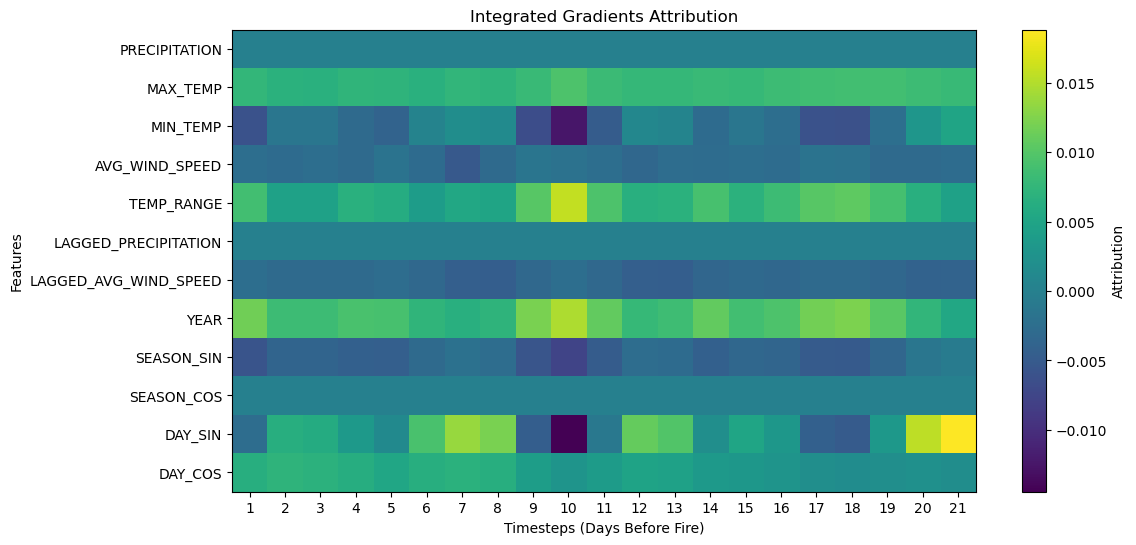

In [83]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def interpolate_inputs(baseline, input, steps=50):
    # Create interpolated inputs between baseline and input
    alphas = tf.linspace(start=0.0, stop=1.0, num=steps)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis]
    delta = input - baseline
    interpolated = baseline + alphas_x * delta
    return interpolated

def compute_gradients(inputs, model, target_class_idx=0):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs, training=False)
        outputs = preds[:, target_class_idx] if preds.shape[-1] > 1 else preds[:, 0]
    grads = tape.gradient(outputs, inputs)
    return grads

def integrated_gradients(input_sample, model, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(input_sample)

    interpolated_inputs = interpolate_inputs(baseline, input_sample, steps)
    grads = []
    for i in range(steps):
        grad = compute_gradients(interpolated_inputs[i:i+1], model)
        grads.append(grad.numpy())
    grads = np.array(grads)
    avg_grads = grads.mean(axis=0)

    integrated_grads = (input_sample.numpy() - baseline.numpy()) * avg_grads
    return integrated_grads

# Select a sample from your validation data predicted as fire
fire_indices = np.where((y_val == 1) & (model.predict(X_val).flatten() >= 0.32))[0]
input_sample = tf.convert_to_tensor(X_val[fire_indices[0:1]], dtype=tf.float32)  # shape: (1, timesteps, features)

# Calculate integrated gradients
attributions = integrated_gradients(input_sample, model)

# Visualize attribution heatmap
plt.figure(figsize=(12, 6))
plt.title("Integrated Gradients Attribution")

# attributions[0] shape: (timesteps, features)
# transpose to put features on y-axis, timesteps on x-axis
plt.imshow(attributions[0].T, cmap='viridis', aspect='auto')

# Label y-axis with feature names
plt.yticks(ticks=np.arange(len(feature_cols)), labels=feature_cols)

# Label x-axis with timestep numbers
plt.xticks(ticks=np.arange(attributions.shape[1]), labels=np.arange(1, attributions.shape[1]+1))

plt.xlabel("Timesteps (Days Before Fire)")
plt.ylabel("Features")
plt.colorbar(label='Attribution')
plt.show()


- Positive values = feature helps predict fire
    - At 21 days before the fire: DAY_SIN (part of your cyclical date encoding) has the strongest positive attribution, meaning the time of year (seasonality captured by sine) here is strongly pushing the model to predict a fire.
    - At 10 days before the fire: YEAR and TEMP_RANGE are positive contributors — maybe indicating a trend in certain years and temperature variability linked with fire risk at that time lag.
- Negative values = feature helps predict no fire
    - At 10 days before the fire: MIN_TEMP and DAY_SIN have the strongest negative attributions, meaning lower minimum temperature and the day cycle there push the model away from predicting a fire.
- **Overall:** 
    - Max temp, temp range, year contribute positively to the model

**Based on attributes, find the most critical time window of identifying a fire**

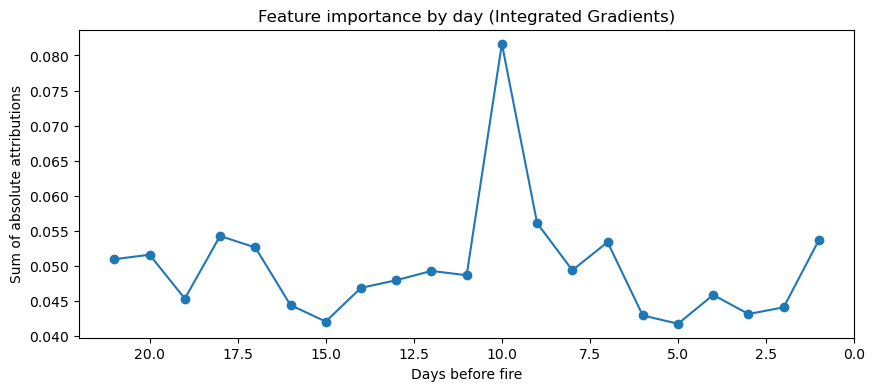

Critical window days before fire (top 20% importance): [ 1  7  9 10 18]


In [84]:
import numpy as np
import matplotlib.pyplot as plt

# attributions shape: (1, timesteps, features)
attr = attributions[0]  # remove batch dim, shape (timesteps, features)

# Sum absolute attribution across features for each day
daily_importance = np.sum(np.abs(attr), axis=1)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(daily_importance)+1), daily_importance, marker='o')
plt.xlabel('Days before fire')
plt.ylabel('Sum of absolute attributions')
plt.title('Feature importance by day (Integrated Gradients)')
plt.gca().invert_xaxis()  # So day 21 is on left (furthest in past)
plt.show()

# You can decide critical window as days where importance is above some threshold, e.g.:
threshold = np.percentile(daily_importance, 80)
critical_days = np.where(daily_importance >= threshold)[0] + 1  # add 1 for day numbering

print(f"Critical window days before fire (top 20% importance): {critical_days}")


Our model indicates the most predictive weather signals for fire risk occur roughly 10 days before the event.

Days 1, 7, 9, 10, and 18 before the fire are where the weather features have the biggest influence on whether a fire is predicted.

**On these days, let's see what features contribute the most importance and are most influential**

In [85]:
import numpy as np
import pandas as pd

# Suppose `attributions` shape is (num_samples, timesteps, num_features)
# And your feature names list in order:
feature_names = ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'TEMP_RANGE',
                 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'YEAR', 'SEASON_SIN',
                 'SEASON_COS', 'DAY_SIN', 'DAY_COS']

critical_days = [1, 7, 9, 10, 18]

# 1. Extract attributions for critical days (assuming day 0 is "1 day before")
# So day 1 corresponds to index 0, day 7 index 6, etc. Adjust if needed.
critical_day_indices = [d - 1 for d in critical_days]

# 2. Aggregate absolute attributions across samples for those days
# Example: mean absolute attribution for each feature at each critical day
mean_abs_attrib = {}
for day_idx, day in zip(critical_day_indices, critical_days):
    # Extract attributions for that day across all samples
    day_attr = np.abs(attributions[:, day_idx, :])  # shape (num_samples, num_features)
    
    # Average across samples
    mean_attr = day_attr.mean(axis=0)
    
    # Create a DataFrame for easier sorting
    df = pd.DataFrame({'feature': feature_names, 'mean_abs_attribution': mean_attr})
    df_sorted = df.sort_values(by='mean_abs_attribution', ascending=False)
    
    mean_abs_attrib[day] = df_sorted

# 3. Print top features per critical day
for day, df in mean_abs_attrib.items():
    print(f"\nTop features on day {day} before fire:")
    print(df.head(5))



Top features on day 1 before fire:
       feature  mean_abs_attribution
7         YEAR              0.011576
4   TEMP_RANGE              0.008780
1     MAX_TEMP              0.007547
11     DAY_COS              0.006438
2     MIN_TEMP              0.006085

Top features on day 7 before fire:
       feature  mean_abs_attribution
10     DAY_SIN              0.013701
1     MAX_TEMP              0.007492
11     DAY_COS              0.006739
7         YEAR              0.006524
4   TEMP_RANGE              0.005508

Top features on day 9 before fire:
      feature  mean_abs_attribution
7        YEAR              0.012187
4  TEMP_RANGE              0.010197
1    MAX_TEMP              0.008128
2    MIN_TEMP              0.006542
8  SEASON_SIN              0.005715

Top features on day 10 before fire:
       feature  mean_abs_attribution
4   TEMP_RANGE              0.015808
7         YEAR              0.014724
10     DAY_SIN              0.014451
2     MIN_TEMP              0.012442
1     MAX_